# RMSD Plots

## Align Structures and get RMSD

In [84]:
import pymol
import pandas as pd
import numpy
import urllib
from pathlib import Path
import numpy as np

from benchmark import get_cath
from pathlib import Path
import urllib


import matplotlib as mpl
mpl.rc("savefig", dpi=300)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (7, 7)
PATH_TO_PDB = Path('/scratch/datasets/pdb/')
from ampal.analyse_protein import (
    sequence_charge,
    sequence_isoelectric_point,
)
import ampal

In [208]:
from typing import List, Tuple
import numpy as np
from sklearn import metrics
from benchmark.get_cath import most_likely_sequence

def calculate_seq_metrics(seq: str):
    """
    Calculates sequence metrics.
    Currently only supports: Charge at pH 7, Isoelectric Point, Molecular Weight
    Parameters
    ----------
    seq: str
        Sequence of residues
    Returns
    -------
    metrics: t.Tuple[float, float, float, float]
        (charge , iso_ph, mw, me)
    """
    charge = sequence_charge(seq)
    iso_ph = sequence_isoelectric_point(seq)
    return charge, iso_ph

def calc_rmsd(model1, model2):
    cmd.delete('all')
    cmd.load(model1)
    cmd.load(model2)
    sel1, sel2 = cmd.get_object_list('all')

    # Select only C alphas
    sel1 += ' and name CA'
    sel2 += ' and name CA'
    cmd.align(sel1, sel2, cycles=0, transform=0, object='aln')
    mapping = cmd.get_raw_alignment(
        'aln')  # e.g. [[('prot1', 2530), ('prot2', 2540)], ...]
    RMSD = cmd.align(sel1, sel2)[0]
    return RMSD

def fetch_pdb(
        pdb_code: str,
        output_folder: Path,
        pdb_request_url: str = "https://files.rcsb.org/download/",
        is_pdb: bool = True,
) -> None:
    """
    Downloads a specific pdb file into a specific folder.
    Parameters
    ----------
    pdb_code : str
        Code of the PDB file to be downloaded.
    output_folder : Path
        Output path to save the PDB file.
    pdb_request_url : str
        Base URL to download the PDB files.
    is_pdb:bool=False
        If True, get .pdb, else get biological assembly.
    """
    if is_pdb:
        pdb_code_with_extension = f"{pdb_code[:4]}.pdb"
    else:
        pdb_code_with_extension = f"{pdb_code[:4]}.pdb1"
    print(f'{pdb_code_with_extension} is missing and will be downloaded!')
    urllib.request.urlretrieve(pdb_request_url + pdb_code_with_extension,
                               filename=output_folder / pdb_code_with_extension)
    
    
    
def score_each(
    df: pd.DataFrame,
    predictions: dict,
    by_fragment: bool = True,
    ignore_uncommon=False,
) -> Tuple[List[float], List[float]]:
    """Calculates accuracy and recall for each protein in DataFrame separately.

    Parameters
    ----------
    df: pd.DataFrame
        DataFrame with CATH fragment info. The frame must have predicted sequence, true sequence and start/stop index of CATH fragment.
    predictions: dict
        Dictionary with loaded predictions.
    by_fragment: bool
        If true scores only CATH fragments, if False, scores entire chain.
    ignore_uncommon=True
        If True, ignores uncommon residues in accuracy calculations.
    score_sequence=False
        True if dictionary contains sequences, False if probability matrices(matrix shape n,20).

    Returns
    --------
    accuracy: List[float]
        List with accuracy for each protein in DataFrame
    recall: List[float]
        List with macro average recall for each protein in Dataframe."""

    accuracy = []
    recall = []
    iso_mae = []
    charge_mae = []
    
    for i, protein in df.iterrows():
        if protein.PDB + protein.chain in predictions:
            start = protein.start
            stop = protein.stop
            predicted_sequence = predictions[protein.PDB + protein.chain]

            # remove uncommon acids
            if ignore_uncommon and type(protein.uncommon_index)==list:
                protein_sequence = "".join(
                    [
                        x
                        for i, x in enumerate(protein.sequence)
                        if i not in protein.uncommon_index
                    ]
                )
                start = start - (np.array(protein.uncommon_index) <= start).sum()
                stop = stop - (np.array(protein.uncommon_index) <= stop).sum()
            else:
                protein_sequence = protein.sequence

            # check length
            if len(protein_sequence) != len(predicted_sequence):
                # prediction is multimer
                if len(predicted_sequence) % len(protein_sequence) == 0:
                    predicted_sequence = predicted_sequence[0 : len(protein_sequence)]
                else:
                    print(
                        f"{protein.PDB}{protein.chain} sequence, predicted sequence and dssp length do not match."
                    )
                    accuracy.append(np.NaN)
                    recall.append(np.NaN)
                    continue
            if by_fragment:
                protein_sequence = protein_sequence[start : stop + 1]
                predicted_sequence = predicted_sequence[start : stop + 1]
            
            accuracy.append(
                metrics.accuracy_score(
                    list(protein_sequence),
                    list(most_likely_sequence(predicted_sequence)),
                )
            )
            recall.append(
                metrics.recall_score(
                    list(protein_sequence),
                    list(most_likely_sequence(predicted_sequence)),
                    average="macro",
                    zero_division=0,
                )
            )
            
            # Calculate MAE for isoelectric point and charge
            ori_charge, ori_iso = calculate_seq_metrics(protein_sequence)
            des_charge, des_iso = calculate_seq_metrics(most_likely_sequence(predicted_sequence))
            iso_mae.append(abs(ori_iso - des_iso))
            charge_mae.append(abs(ori_charge - des_charge))

            
        else:
            accuracy.append(np.NaN)
            recall.append(np.NaN)

    return accuracy, recall, iso_mae, charge_mae


def get_rmsd(model_name, model_path, pdb_path, pdb_codes):
    pdb_rmsd = []
    for pdb_code in pdb_codes:
        baseline_path =  pdb_path / f"{pdb_code[:4]}.pdb1"
        curr_model_path = model_path / f"{model_name}_{pdb_code}A_relaxed_model_3.pdb"
        assert baseline_path.exists(), f"{baseline_path} does not exist"
        if curr_model_path.exists():
            rmsd = calc_rmsd(baseline_path, curr_model_path)
        else:
            #print(f"{curr_model_path} does not exist")
            rmsd = np.nan
            mae_iso = np.nan
            mae_charge = np.nan
        pdb_rmsd.append(rmsd)
    return pdb_rmsd

def get_all_rmsd(model_name, model_path, pdb_path, pdb_codes):
    pdb_rmsd = []
    pdb_charge = []
    pdb_iso = []
    for pdb_code in pdb_codes:
        baseline_path =  pdb_path / f"{pdb_code[:4]}.pdb1"
        curr_model_path = model_path / f"{model_name}_{pdb_code}A_relaxed_model_3.pdb"
        assert baseline_path.exists(), f"{baseline_path} does not exist"
        if curr_model_path.exists():
            rmsd = calc_rmsd(baseline_path, curr_model_path)
            # Original:
            original_pdb = ampal.load_pdb(baseline_path)
            original_sequence = original_pdb[0].sequences[0]
            ori_charge, ori_iso = calculate_seq_metrics(original_sequence)
            # Designed:
            design_pdb = ampal.load_pdb(curr_model_path)
            design_sequence = design_pdb[0].sequence
            des_charge, des_iso = calculate_seq_metrics(design_sequence)
            # Calculate MAE:
            mae_iso = abs(ori_iso - des_iso)
            mae_charge = abs(ori_charge - des_charge)
        else:
            print(f"{curr_model_path} does not exist")
            rmsd = np.nan
            mae_iso = np.nan
            mae_charge = np.nan
        pdb_rmsd.append(rmsd)
        pdb_charge.append(mae_charge)
        pdb_iso.append(mae_iso)
    return pdb_rmsd, pdb_charge, pdb_iso

        

pymol.pymol_argv = ['pymol', '-qc']
pymol.finish_launching()
cmd = pymol.cmd


In [154]:
model_names = ['evoEF2', 'rosetta', 'ProDCONN', 'DenseNet', 'DenseCPD', "ProteinMPNN", 'TIMED', #'TIMED_Deep',
               'TIMED_Polar', 'TIMED_Charge' ]
path_to_model_structures = Path('/scratch/alphafold/localcolabfold/publication_2023/')
path_to_benchmark_structures = Path('/scratch/timed_dataset/benchmark_pdbs/')
better_names = ['EvoEF2', 'Rosetta', 'ProDCoNN', 'DenseNet', 'DenseCPD', "ProteinMPNN",'TIMED', #'TIMED_Deep',
                'TIMED_Polar', 'TIMED_Charge' ]

Create accuracy file and divide by fold class

In [199]:
cath_location = "/scratch/pdb-compare/sequence-recovery-benchmark/cath-domain-description-file.txt"
cath_df = get_cath.read_data(cath_location)
df = get_cath.filter_with_user_list(cath_df,'/scratch/pdb-compare/sequence-recovery-benchmark/dataset_visualization/crystal_structure_set.txt') #single_chain.txt')
df = get_cath.append_sequence(df, PATH_TO_PDB)

no atoms read before TER record 
TER                                                                             
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


proteinMPNN fails on these structures so we must remove them:

```
/scratch/alphafold/localcolabfold/publication_2023/ProteinMPNN/ProteinMPNN_1g3pA_relaxed_model_3.pdb does not exist
/scratch/alphafold/localcolabfold/publication_2023/ProteinMPNN/ProteinMPNN_2v3iA_relaxed_model_3.pdb does not exist
/scratch/alphafold/localcolabfold/publication_2023/ProteinMPNN/ProteinMPNN_4efpA_relaxed_model_3.pdb does not exist
/scratch/alphafold/localcolabfold/publication_2023/ProteinMPNN/ProteinMPNN_1l0sA_relaxed_model_3.pdb does not exist
/scratch/alphafold/localcolabfold/publication_2023/ProteinMPNN/ProteinMPNN_3swgA_relaxed_model_3.pdb does not exist
````


In [200]:
len(df)

595

In [140]:
# pdb_codes_to_remove = ['1g3p', '2v3i', '4efp', '1l0s', '3swg']
# # Remove rows with specified PDB codes
# df = df[~df['PDB'].isin(pdb_codes_to_remove)]
# df

,PDB,chain,class,architecture,topology,hsf,start,stop,sequence,dssp,uncommon_index,resolution
5028,3e3v,A,1,10,10,10,98,153,LADDISKGYNAALNYLSYQLRTRKEVEDKLRSLDIHEDYISEIINK...,HHHHHHHHHHHHHHHHSS HHHHHTTSGGGT HHHHHHHHHH...,NaN,2.04
19576,5dic,A,1,10,238,20,0,114,HLELTEEQKAKVKVHFDECVKQEKVSEEEATKLRNKDYANPTPAMK...,HHHHHHHHHHHHHHHHHTT HHHHHHHHTT SS HHHH...,NaN,1.19
71296,1dvo,A,1,10,1710,10,0,151,PPKWKVKKQKLAEKAAREAELTAKKAQARQALSIYLNLPTLDEAVN...,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHGGGGSS HHHHHH...,NaN,2.00
71498,3cxb,A,1,10,1740,30,172,229,NTKEAWWKVLWEKIKDFFFSTGKAKADRCLHEMLFAERAPTRERLT...,HHHHHHHHHHGGGB TTHHHHHHHHHHHHHSSSS HHHHH...,NaN,2.60
72938,3rf0,A,1,10,3210,10,0,198,HQDIRQRTAKSLADHYNIDREQARRVLETTEQLYTQWLAQNTKLVQ...,HHHHHHHHHHHHHHHT HHHHHHHHHHHHHHHHHHHHH GGG ...,"[57, 70, 100]",1.80
82474,2ra1,A,1,20,58,770,166,228,TDVATVVSQAKAQMKEAYYTYSHTVTETGQFPDIKDVYAAYNKAKQ...,HHHHHHHHHHHHHHHHHHHHHHHHHHSS HHHHHHHHHHHHH...,NaN,2.41
86819,1a41,A,1,20,120,380,127,220,NAKRDRIFVRVYNVMKRINCFINKNIKKSSTDSNYQLAVFMLMETM...,HHHHHHHHHHHHHHHHHHHHHHHHTTSTTT TTHHHHHHHHHHH ...,NaN,2.30
107751,3gia,A,1,20,1740,10,0,432,LKNKKLSLWEAVSMAVGVMIGASIFSIFGVGAKIAGRNLPETFILS...,B HHHHHHHHHHHHHHHHTTTSHHHHHHHHGGGHHHHHHHH...,NaN,2.32
108175,3dad,A,1,25,10,10,0,323,SVVTVRVQYLEDTDPFASANFPEPRRAPTCSLDGALPLGAQIPAVH...,EEEEEEEE SSTTS SSSS EEEEETTS GGGTHHHHH...,NaN,2.30
108190,2of3,A,1,25,10,10,0,265,AELLLSDNEDKKQRIKEEKQLKLVKWNFQAPTDEHISQLQTLLGNQ...,SB SSHHHHHHHHHHTT S S SS HHHHHHHHHHHHTT...,NaN,1.90


In [ ]:
from copy import copy
for model_name in model_names:
	print(model_name)
	path_to_file = Path(f"timed_cb_fix/{model_name}.csv")
	# select only monomers
	new_df = copy(df)
	# choose your model
	with open(path_to_file.with_suffix('.txt')) as datasetmap:
	    predictions = get_cath.load_prediction_matrix(new_df,
	                                                  path_to_file.with_suffix(
	                                                      '.txt'), path_to_file)
	accuracy, recall, pdb_iso, pdb_charge = score_each(new_df, predictions, by_fragment=False)
	model_path = path_to_model_structures / model_name
	pdb_rmsd = get_rmsd(model_name, model_path, path_to_benchmark_structures, list(new_df.PDB.values))
	new_df['accuracy'] = accuracy
	new_df['recall'] = recall
	new_df['rmsd'] = pdb_rmsd
	new_df['charge'] = pdb_charge
	new_df['iso'] = pdb_iso
	new_df['resolution'] = df['resolution'].values
	new_df.to_csv(f"performance/{model_name}_performance.csv")

evoEF2


In [156]:
model_names[:-2]

['evoEF2',
 'rosetta',
 'ProDCONN',
 'DenseNet',
 'DenseCPD',
 'ProteinMPNN',
 'TIMED']

In [157]:
nord_palette = ["#66788fff","#f0f4f9ff","#9fd5c7ff","#849fc2ff","#5173b8ff", "#464646", "#db6b75ff", "#EBCB8B","#85bb63ff","#c6a2c6ff", "#adadad"]

## RMSD Plot

evoEF2
rosetta
ProDCONN
DenseNet
DenseCPD
ProteinMPNN
TIMED
evoEF2
rosetta
ProDCONN
DenseNet
DenseCPD
ProteinMPNN
TIMED
evoEF2
rosetta
ProDCONN
DenseNet
DenseCPD
ProteinMPNN
TIMED
evoEF2
rosetta
ProDCONN
DenseNet
DenseCPD
ProteinMPNN
TIMED


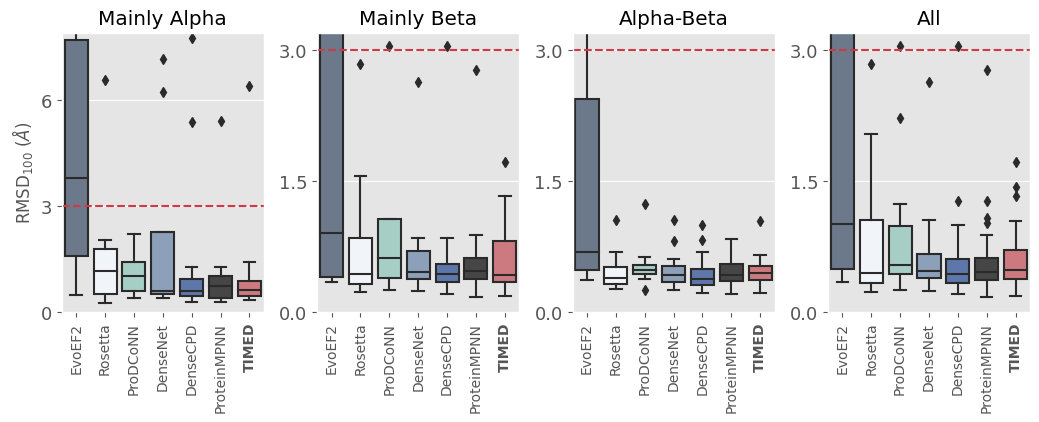

In [158]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 1.5

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names[:-2]):
        print(model_name)
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_rmsd, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('RMSD$_{100}$ ($\AA$)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))
    #axes[c-1].axes.xaxis.set_visible(False)
    axes[c-1].set_xticklabels(better_names[:-2], rotation=90)
    labels = axes[c-1].get_xticklabels()
    #if 0 <= final_model_index < len(labels):
    labels[-1].set_weight('bold')
    if c-1 == 0:
        axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    else:
        axes[c-1].set_ylim(ymin=0, ymax=3.2)
    axes[c-1].axhline(3,  ls='--', color='#CF3A46')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img_2023/boxplot_RMSD_Norm_{RMSD_100}.pdf", dpi=300)
plt.show()
plt.close()

## Accuracy

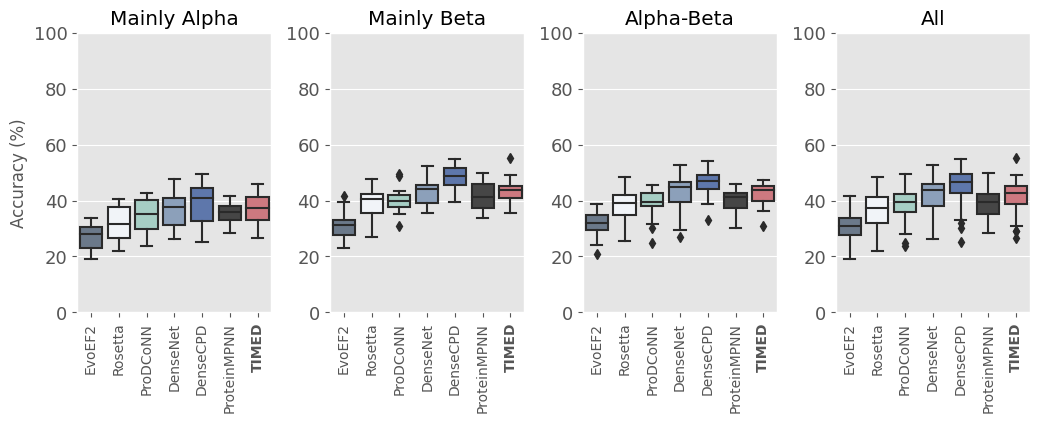

In [159]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 1.5

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names[:-2]):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(z)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_accuracy, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Accuracy (%)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    #axes[c-1].axes.xaxis.set_visible(False)
    axes[c-1].set_xticklabels(better_names[:-2], rotation=90)
    labels = axes[c-1].get_xticklabels()
    #if 0 <= final_model_index < len(labels):
    labels[-1].set_weight('bold')
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=0, ymax=100)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img_2023/boxplot_accuracy.pdf", dpi=300)
plt.show()
plt.close()

## Macro-Recall

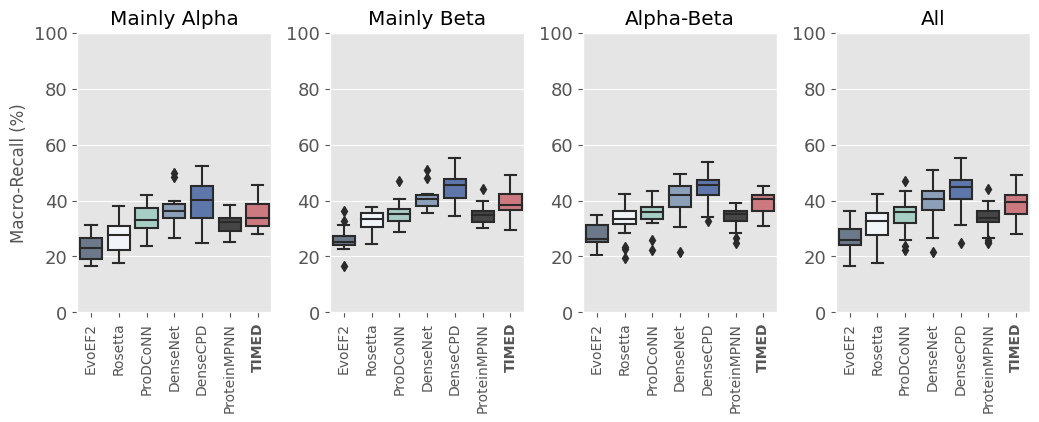

In [160]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 1.5

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names[:-2]):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(z)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_recall, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Macro-Recall (%)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
#    axes[c-1].axes.xaxis.set_visible(False)
    axes[c-1].set_xticklabels(better_names[:-2], rotation=90)
    labels = axes[c-1].get_xticklabels()
    #if 0 <= final_model_index < len(labels):
    labels[-1].set_weight('bold')
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=0, ymax=100)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img_2023/boxplot_recall.pdf", dpi=300)
plt.show()
plt.close()

## Charge

TIMED
TIMED_Polar
TIMED_Charge
TIMED
TIMED_Polar
TIMED_Charge
TIMED
TIMED_Polar
TIMED_Charge
TIMED
TIMED_Polar
TIMED_Charge


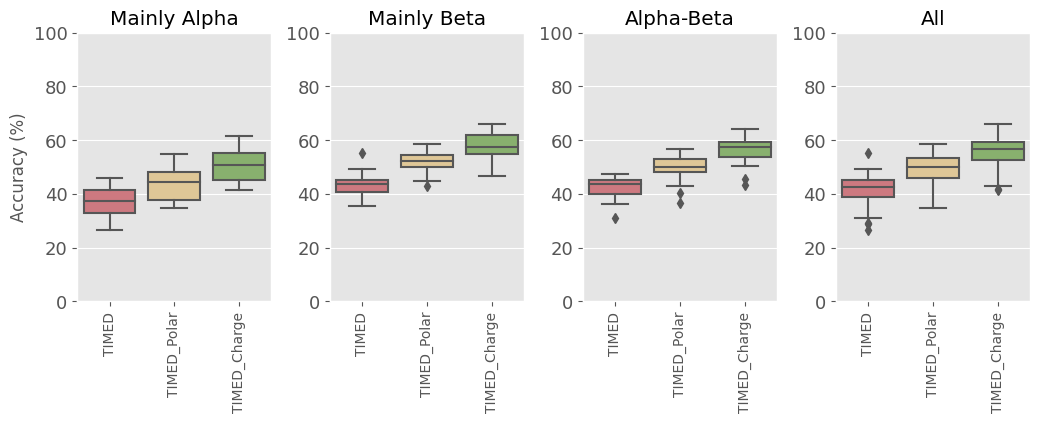

In [179]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 1.5

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names[6:]):
        print(model_name)
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(z)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_accuracy, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette[6:]))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Accuracy (%)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    # axes[c-1].axes.xaxis.set_visible(False)
    axes[c-1].set_xticklabels(better_names[6:], rotation=90)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=0, ymax=100)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img_2023/boxplot_accuracy_chargepolar.pdf", dpi=300)
plt.show()
plt.close()

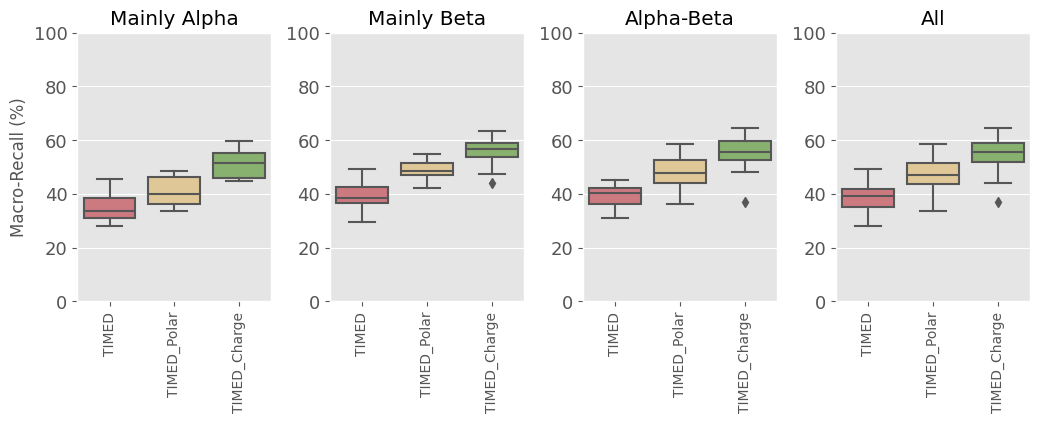

In [185]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns



RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names[6:]):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(z)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_recall, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette[6:]))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Macro-Recall (%)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].set_xticklabels(better_names[6:], rotation=90)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=0, ymax=100)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img_2023/boxplot_recall_chargepolar.pdf", dpi=300)
plt.show()
plt.close()

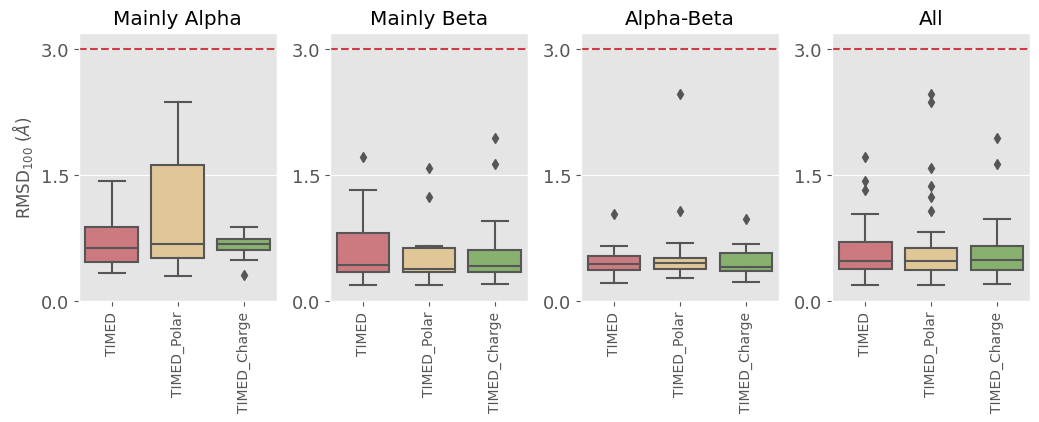

In [182]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns




RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names[6:]):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(x)

        median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_rmsd, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette[6:]))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('RMSD$_{100}$ ($\AA$)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))
    axes[c-1].set_xticklabels(better_names[6:], rotation=90)

    axes[c-1].set_ylim(ymin=0, ymax=3.2)
    axes[c-1].axhline(3,  ls='--', color='#CF3A46')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img_2023/boxplot_RMSD_Norm_polarcharge.pdf", dpi=300)
plt.show()
plt.close()

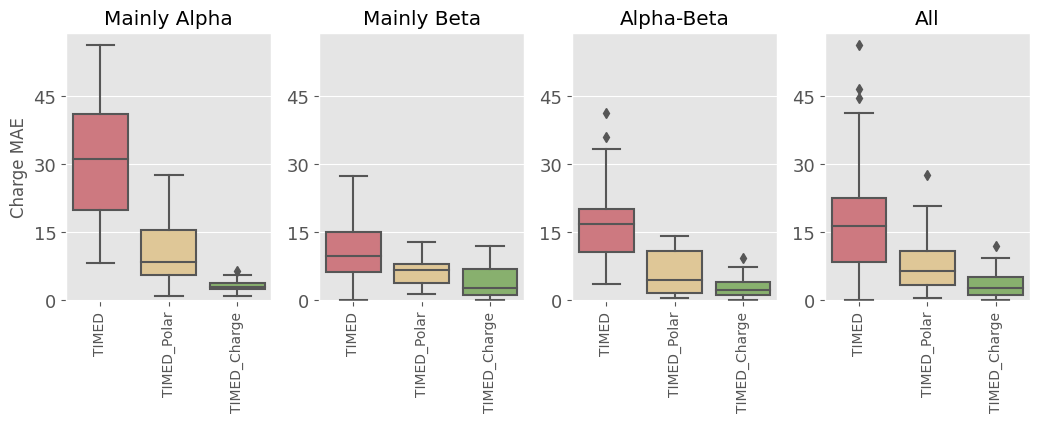

In [183]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns



RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_charge = []
    data_accuracy = []
    sequences = []
    data_recall = []

    median = 0
    for i, model_name in enumerate(model_names[6:]):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.charge.to_numpy()
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_charge.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_charge, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette[6:]))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Charge MAE')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].set_xticklabels(better_names[6:], rotation=90)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=-0.3, ymax=59)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img_2023/boxplot_charge_chargepolar.pdf", dpi=300)
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

## Isoelectric Point

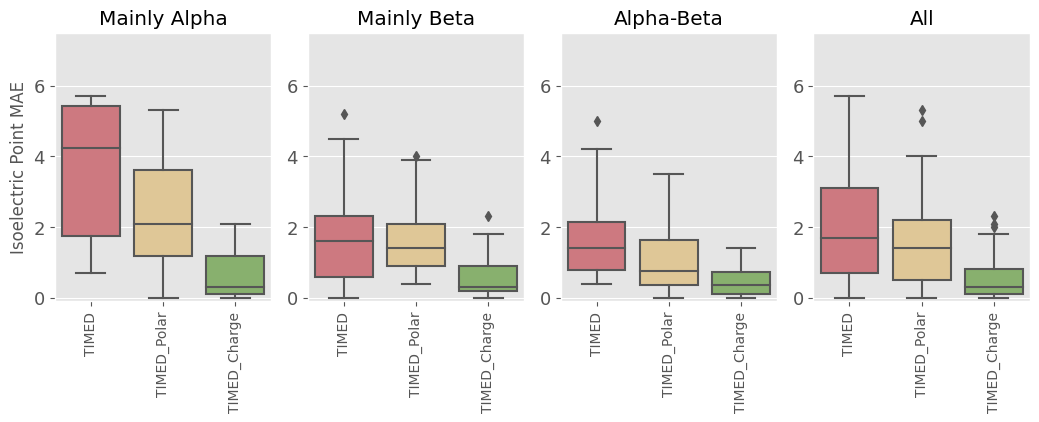

In [184]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns



RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_charge = []
    data_accuracy = []
    sequences = []
    data_recall = []

    median = 0
    for i, model_name in enumerate(model_names[6:]):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)
        x = df.iso.to_numpy()
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        data_charge.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_charge, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette[6:]))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Isoelectric Point MAE')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].set_xticklabels(better_names[6:], rotation=90)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=-.1, ymax=7.5)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img_2023/boxplot_iso_chargepolar.pdf", dpi=300)
plt.show()
plt.close()

NameError: name 'new_dfpdb_class_map' is not defined

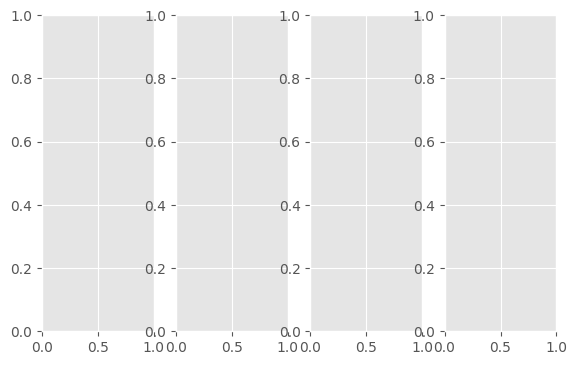

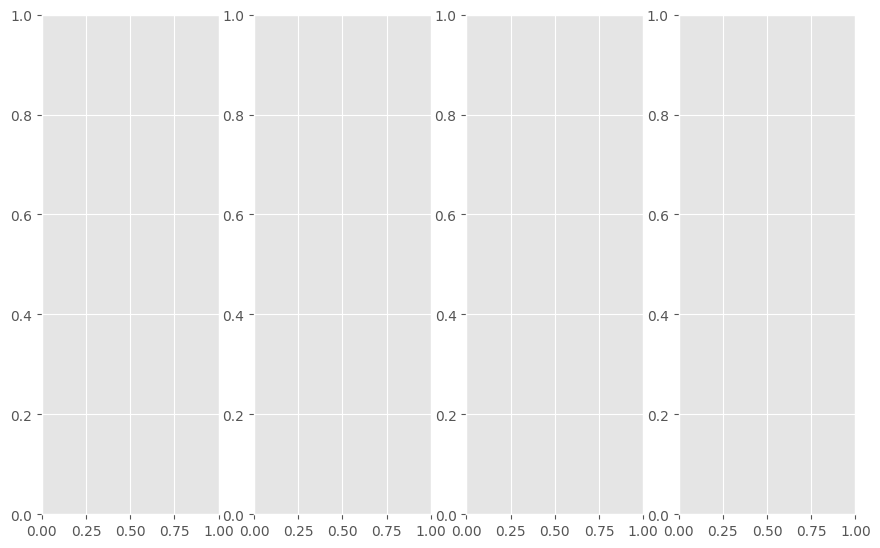

In [187]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Setting up plot aesthetics
plt.style.use("ggplot")
nice_fonts = {
    "font.family": "serif",
    "font.serif": "Times New Roman",
}
plt.rcParams.update(nice_fonts)

def set_size(width, fraction=1):
    # Function to set figure size
    fig_width_pt = width * fraction
    inches_per_pt = 1 / 72.27
    golden_ratio = (5**0.5 - 1) / 2
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio
    return (fig_width_in, fig_height_in)

# Creating a figure with 4 subplots in one row
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=set_size(480))

class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
new_dfpdb_class_map

In [189]:
len(pdb_class_map)

53

### Correlation Macro-Recall vs Resolution

['evoEF2', 'rosetta', 'ProDCONN', 'DenseNet', 'DenseCPD', 'ProteinMPNN', 'TIMED', 'TIMED_Polar', 'TIMED_Charge'] [-0.5224060790803169, -0.5522409668095661, -0.6441360901880444, -0.7656400299676416, -0.6632963200901849, -0.7970846732970525, -0.5761996645764907, -0.7239746593147507, -0.6839378226955306]
['evoEF2', 'rosetta', 'ProDCONN', 'DenseNet', 'DenseCPD', 'ProteinMPNN', 'TIMED', 'TIMED_Polar', 'TIMED_Charge'] [-0.34082918721888256, -0.6312600074937471, -0.4259929324212436, -0.5266342653918316, -0.41310062815971954, -0.405550869908475, -0.6838164102001305, -0.5803863397008914, -0.24914880434044634]
['evoEF2', 'rosetta', 'ProDCONN', 'DenseNet', 'DenseCPD', 'ProteinMPNN', 'TIMED', 'TIMED_Polar', 'TIMED_Charge'] [-0.1695374667451801, -0.3330541815048395, -0.22841218193462345, -0.2561272999496589, -0.20682605269806667, -0.31309280699392555, -0.09502767360262461, -0.032667286276822825, -0.08541502782780858]
['evoEF2', 'rosetta', 'ProDCONN', 'DenseNet', 'DenseCPD', 'ProteinMPNN', 'TIMED', 

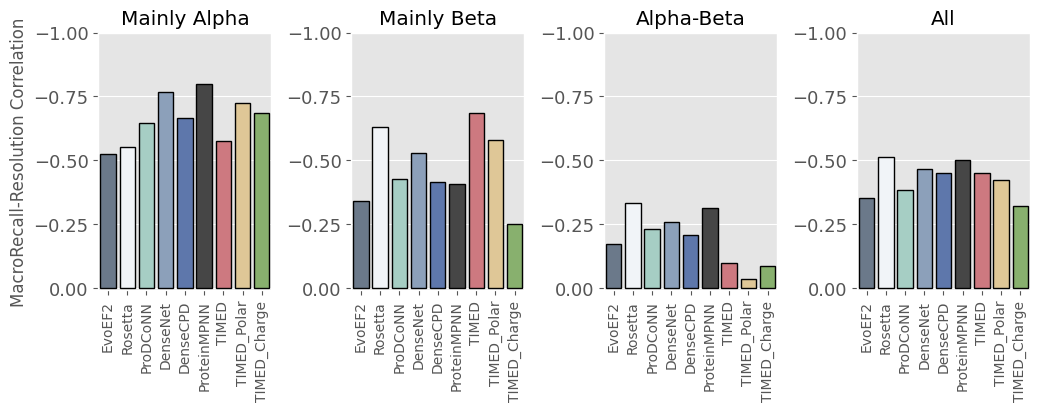

In [175]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr


def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in*1.3


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_charge = []
    data_accuracy = []
    sequences = []
    data_recall = []
    data_correlation = []
    data_pvalue = []
    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)
        if c < 4:
            x = df[df["class"]==c].resolution.values
            y = df[df["class"]==c].recall.values
        else:
        # Select all
            current_map = pdb_class_map != 0
            x = df[df["class"]!=0].resolution.values
            y = df[df["class"]!=0].recall.values
        curr_correlation, curr_pvalue = pearsonr(x ,y)
        data_pvalue.append(curr_pvalue)
        data_correlation.append(curr_correlation)
        # if model_name == "timed_deep":
        #     print(c)
        #     print(df.recall.values[current_map])
        #     print(df.resolution.values[current_map])
        #     print(pearsonr(df.recall.values[current_map] ,df.resolution.values[current_map]))
    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    #prova = pd.DataFrame({"values":data_correlation, "model":model_names})
    print(model_names, data_correlation)
    sns.barplot(x=model_names, y=data_correlation,  ax = axes[c-1], linewidth=1, edgecolor='black', palette=sns.set_palette(nord_palette))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('MacroRecall-Resolution Correlation')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].set_xticklabels(better_names, rotation=90)
    # axes[c-1].axes.xaxis.set_visible(False)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=0.01, ymax=-1)
    #axes[c-1].axhline(3,  ls='--')
    #plt.gca().set_xticklabels(model_names, rotation=0)

    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img_2023/correlation_resolution_all.pdf", dpi=300)

plt.show()
plt.close()

# Unbalanced

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


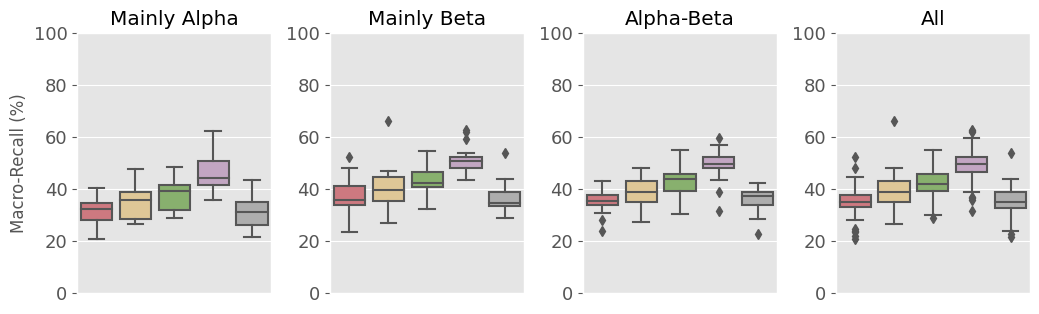

In [7]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names[5:] + ['timed_unbalanced']):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(z)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_recall, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette[5:]))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Macro-Recall (%)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].axes.xaxis.set_visible(False)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=0, ymax=100)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img/boxplot_recall_unbalanced.pdf", dpi=300)
plt.show()
plt.close()

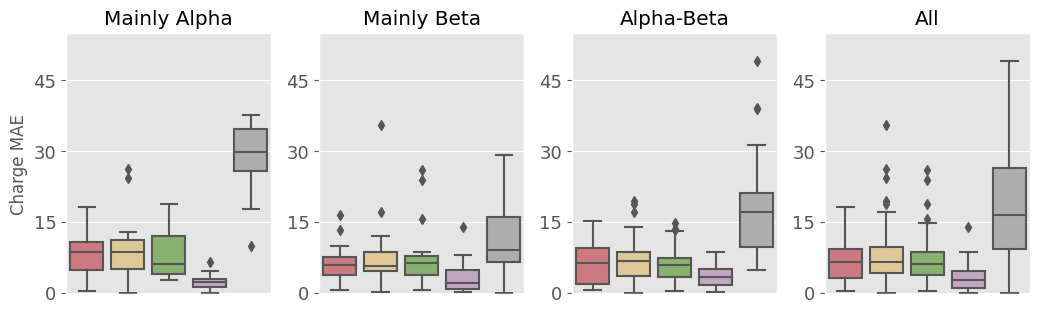

In [289]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_charge = []
    data_accuracy = []
    sequences = []
    data_recall = []

    median = 0
    for i, model_name in enumerate(model_names[5:] + ['timed_unbalanced']):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.charge.to_numpy()
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_charge.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_charge, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette[5:]))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Charge MAE')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].axes.xaxis.set_visible(False)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=-0.3, ymax=55)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img/boxplot_charge_unbalanced.pdf", dpi=300)
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

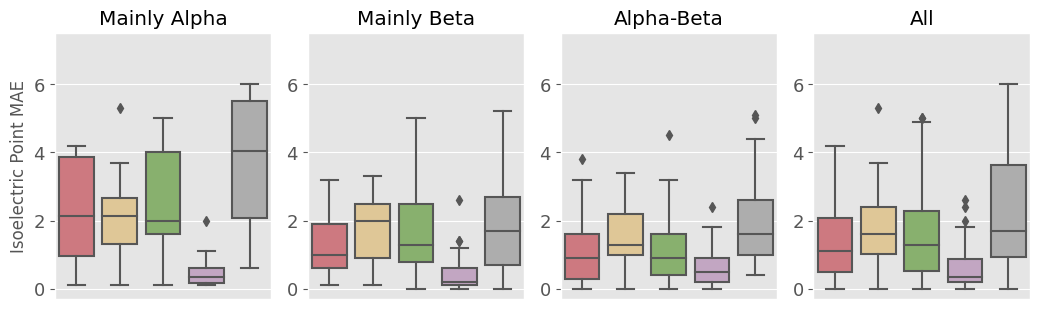

In [301]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_charge = []
    data_accuracy = []
    sequences = []
    data_recall = []

    median = 0
    for i, model_name in enumerate(model_names[5:] + ['timed_unbalanced']):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.iso.to_numpy()
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_charge.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_charge, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette[5:]))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Isoelectric Point MAE')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].axes.xaxis.set_visible(False)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=-0.3, ymax=7.5)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img/boxplot_iso_unbalanced.pdf", dpi=300)
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

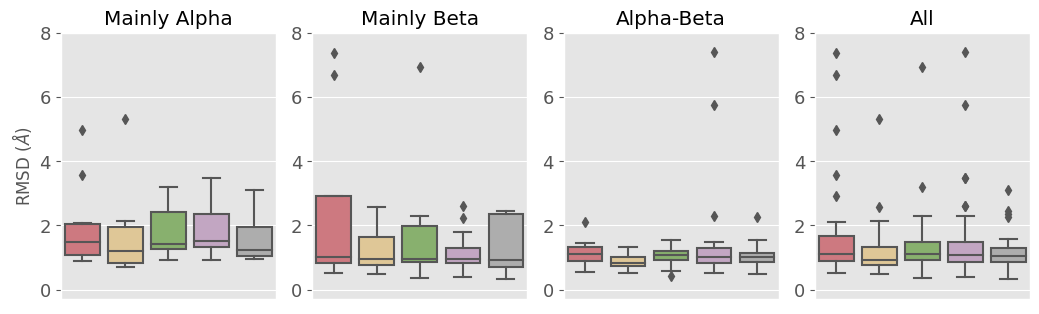

In [300]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_charge = []
    data_accuracy = []
    sequences = []
    data_recall = []

    median = 0
    for i, model_name in enumerate(model_names[5:] + ['timed_unbalanced']):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.rmsd.to_numpy()
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_charge.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = True
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_charge, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette[5:]))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('RMSD ($\AA$)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].axes.xaxis.set_visible(False)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=-0.3, ymax=8)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.savefig(f"final_img/boxplot_rmsd_unbalanced.pdf", dpi=300)
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

<AxesSubplot:xlabel='resolution', ylabel='recall'>

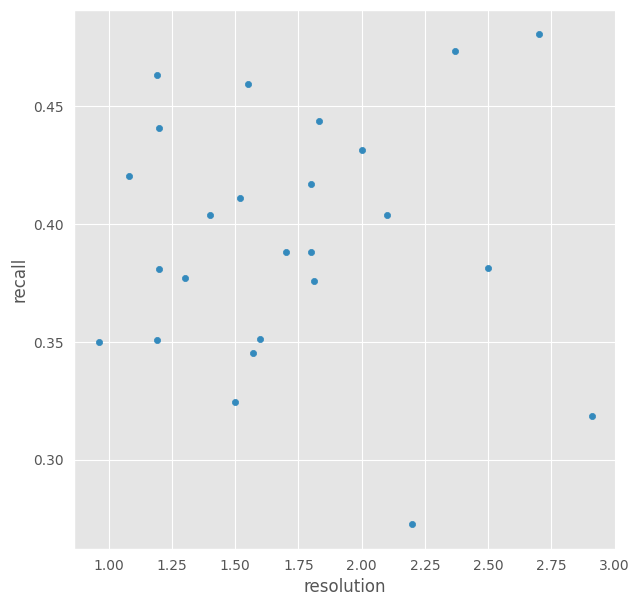

In [ ]:
df = pd.read_csv(f"performance/timed_deep_performance.csv")
df[df["class"]==3].plot.scatter(x='resolution', y='recall')

In [107]:
x = df[df["class"]==1].resolution.values
y = df[df["class"]==1].recall.values
pearsonr(x, y)

(-0.9199233163814431, 2.2642251515380867e-05)

In [109]:
x = df[df["class"]==2].resolution.values
y = df[df["class"]==2].recall.values
pearsonr(x, y)

(-0.5187377324649356, 0.01597823095857528)

In [110]:
x = df[df["class"]==3].resolution.values
y = df[df["class"]==3].recall.values
pearsonr(x, y)

(-0.039955977860557663, 0.8496012597718485)

In [105]:
df[df["class"]==1].resolution.values

array([2.3 , 2.  , 1.9 , 2.41, 2.6 , 2.3 , 2.04, 2.32, 1.8 , 1.64, 2.3 ,
       1.19])

In [292]:
palette

['#66788fff',
 '#f0f4f9ff',
 '#9fd5c7ff',
 '#849fc2ff',
 '#5173b8ff',
 '#db6b75ff',
 '#EBCB8B',
 '#85bb63ff',
 '#c6a2c6ff',
 '#adadad']

In [48]:
prova = pd.DataFrame({"model":model_names, "values":data_correlation})
data_correlation

[-0.3950323505220801,
 -0.4987888216302826,
 -0.31064835262533497,
 -0.5695460652513684,
 -0.6690004717734102,
 -0.4171143972999619,
 -0.4876305582566362,
 -0.44667592999454614,
 -0.4395768412949919,
 -0.5962207692674284,
 -0.41908078261313486,
 -0.43725099783947363]

In [293]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use("ggplot")
palette= nord_palette
print(palette)
def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names[5:]+['timed_unbalanced']):
        print(model_name)
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        # print(x)
        # raise ValueError
        # except:
        #     pass
        # print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        print(f"{model_name} has {len(y[y < 2])} for class {class_names[c-1]}")

        data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

        cumulative_rmsd = []
        thresholds = np.arange(0, 10, 2)

        for idx, t in enumerate(thresholds):

            if idx == 0:
                percentage = ((len(y[y < t])) / len(y))
            else:
                percentage = ((len(y[y < t])-cumulative_rmsd[-1]) / len(y))
            cumulative_rmsd.append(percentage)
        if model_name == "timed_unbalanced":
            axes[c-1].plot(thresholds, cumulative_rmsd, label="TIMED_Unbalanced", linewidth=5, color=palette[-1])
        else:
            axes[c-1].plot(thresholds, cumulative_rmsd, label=better_names[5:][i], linewidth=5, color=palette[5:][i])

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD

    # xtickNames = plt.setp(axes[c-1], xticklabels=models)
    # plt.setp(xtickNames, rotation=90, fontsize=5)
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    # ax.set_xlabel('RMSD ($\AA$)') #, fontsize=20)
    axes[0].set_ylabel('% Structures (%)') #, fontsize=20)
    # axes[0].set_ylabel('Density') #, fontsize=20)
    # axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))
    axes[c-1].xaxis.set_major_locator(plt.MaxNLocator(3))
    # axes[c-1].axvline(2, color='k', linestyle='dashed', linewidth=1)
    # axes[c-1].text(50 * 0.9, 2.2, '2 ($\AA$)', fontsize=18)
    # axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))

    # axes[c-1].set_xticklabels(tick_labels.astype(int))
    # axes[c-1].axes.xaxis.set_visible(False)
    # axes[c-1].set_yticklabels([])
    # axes[c-1].set_xticklabels([])
    axes[c-1].set_ylim(ymin=0) #, ymax=np.max(data_rmsd))
    axes[c-1].set_xlim(xmin=0, xmax=6) #, ymax=np.max(data_rmsd))
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
fig.text(0.5, 0.01, 'RMSD ($\AA$)', ha='center')
# plt.legend()
legend = plt.legend(ncol = 5, framealpha=1, frameon=True, bbox_to_anchor=(0.5, -0.15))



def export_legend(legend, filename="final_img/legend_unbalanced.pdf", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox)

export_legend(legend)
# plt.legend([],[], frameon=False)
#
# fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical')
plt.tight_layout()
# plt.savefig(f"hist_RMSD.eps", dpi=300)
plt.close()

['#66788fff', '#f0f4f9ff', '#9fd5c7ff', '#849fc2ff', '#5173b8ff', '#db6b75ff', '#EBCB8B', '#85bb63ff', '#c6a2c6ff', '#adadad']
timed
timed has 8 for class Mainly Alpha
timed_deep
timed_deep has 9 for class Mainly Alpha
TIMED_polar_fix
TIMED_polar_fix has 8 for class Mainly Alpha
TIMED_charge
TIMED_charge has 8 for class Mainly Alpha
timed_unbalanced
timed_unbalanced has 9 for class Mainly Alpha
timed
timed has 15 for class Mainly Beta
timed_deep
timed_deep has 16 for class Mainly Beta
TIMED_polar_fix
TIMED_polar_fix has 16 for class Mainly Beta
TIMED_charge
TIMED_charge has 17 for class Mainly Beta
timed_unbalanced
timed_unbalanced has 15 for class Mainly Beta
timed
timed has 23 for class Alpha-Beta
timed_deep
timed_deep has 24 for class Alpha-Beta
TIMED_polar_fix
TIMED_polar_fix has 24 for class Alpha-Beta
TIMED_charge
TIMED_charge has 22 for class Alpha-Beta
timed_unbalanced
timed_unbalanced has 23 for class Alpha-Beta
timed
timed has 46 for class All
timed_deep
timed_deep has 49 for

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ipykernel_launcher.py:186: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Use the colorbar set_ticks() method instead.


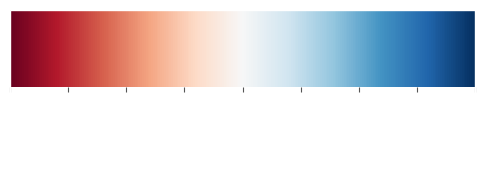

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Define the values
values = [-1, 0, 1]

# Define the colormap
cmap = plt.cm.RdBu

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))

# Normalize the values to range from 0 to 1
norm = plt.Normalize(min(values), max(values))

# Create a scalar mappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create the colorbar
cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')

# Set the y-axis limits
ax.set_ylim(0, 1)

# Remove the x-axis ticks and labels
ax.set_xticks([])
ax.set_xticklabels([])

# Remove the y-axis
ax.get_yaxis().set_visible(False)

# Export the plot to PDF
#plt.savefig('colorbar_plot.pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [32]:
df.loc[30]

Unnamed: 0                                                       13
Unnamed: 0.1                                                 118376
PDB                                                            3klk
chain                                                             A
class                                                             2
architecture                                                     10
topology                                                        270
hsf                                                              10
start                                                             0
stop                                                             45
sequence          QYYIDPTTGQPRKNFLLQNGNDWIYFDKDTGAGTNALKLQFDKGTI...
dssp                 EETTTTEE  SEEEEETTEEEEE TTT  EEEGGG    TT  ...
uncommon_index                                                  NaN
resolution                                                 1.650000
accuracy                                        

In [29]:
p = sns.color_palette("hls", len(model_names))


In [31]:
p[0]

(0.86, 0.3712, 0.33999999999999997)

In [41]:
sns.color_palette("muted")


[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [22]:
calculate_seq_metrics(new_df.iloc[0].sequence)

(11.78943899546267, 10.000000000000007)

In [23]:
calculate_seq_metrics(new_df.iloc[1].sequence)

(-13.129709357807064, 5.100000000000003)

In [25]:
abs(calculate_seq_metrics(new_df.iloc[0].sequence)[0] - calculate_seq_metrics(new_df.iloc[1].sequence)[0])

24.919148353269733

## Unrelaxed Models

In [20]:
def get_all_rmsd_unrelaxed(model_name, model_path, pdb_path, pdb_codes):
    pdb_rmsd = []
    pdb_charge = []
    pdb_iso = []
    for pdb_code in pdb_codes:
        baseline_path =  pdb_path / f"{pdb_code[:4]}.pdb1"
        curr_model_path = model_path / f"{model_name}_{pdb_code}A_relaxed_model_4.pdb"
        assert baseline_path.exists(), f"{baseline_path} does not exist"
        if curr_model_path.exists():
            rmsd = calc_rmsd(baseline_path, curr_model_path)
            # Original:
            original_pdb = ampal.load_pdb(baseline_path)
            original_sequence = original_pdb[0].sequences[0]
            ori_charge, ori_iso = calculate_seq_metrics(original_sequence)
            # Designed:
            design_pdb = ampal.load_pdb(curr_model_path)
            print(design_pdb)
            design_sequence = design_pdb.sequences[0]
            des_charge, des_iso = calculate_seq_metrics(design_sequence)
            # Calculate MAE:
            mae_iso = abs(ori_iso - des_iso)
            mae_charge = abs(ori_charge - des_charge)
        else:
            print(f"{curr_model_path} does not exist")
            rmsd = np.nan
            mae_iso = np.nan
            mae_charge = np.nan
        pdb_rmsd.append(rmsd)
        pdb_charge.append(mae_charge)
        pdb_iso.append(mae_iso)
    return pdb_rmsd, pdb_charge, pdb_iso


In [21]:
from copy import copy
for model_name in model_names:
	#model_name = 'skilled-wind-134-timed_hs1000_l2_dp03_weighted'
	path_to_file = Path(f"timed_paper_2023/{model_name}.csv")
	print(model_name)
	print(path_to_file.exists())
	print(path_to_file.with_suffix('.txt').exists())
	# select only monomers
	new_df = copy(df)
	# choose your model
	with open(path_to_file.with_suffix('.txt')) as datasetmap:
	    predictions = get_cath.load_prediction_matrix(new_df,
	                                                  path_to_file.with_suffix(
	                                                      '.txt'), path_to_file)
	accuracy, recall = get_cath.score_each(new_df, predictions, by_fragment=False)
	model_path = path_to_model_structures / model_name
	pdb_rmsd, pdb_charge, pdb_iso = get_all_rmsd_unrelaxed(model_name, model_path, path_to_benchmark_structures, list(new_df.PDB.values))
	new_df['accuracy'] = accuracy
	new_df['recall'] = recall
	new_df['rmsd'] = pdb_rmsd
	new_df['charge'] = pdb_charge
	new_df['iso'] = pdb_iso
	new_df.to_csv(f"performance/{model_name}_model4_performance.csv")

evoEF2
True
True
['1a41', 'evoEF2_1a41A_relaxed_model_4']
<Assembly (evoEF2_1a41A_relaxed_model_4) containing 1 Polypeptide>
['1ds1', 'evoEF2_1ds1A_relaxed_model_4']
<Assembly (evoEF2_1ds1A_relaxed_model_4) containing 1 Polypeptide>
['1dvo', 'evoEF2_1dvoA_relaxed_model_4']
<Assembly (evoEF2_1dvoA_relaxed_model_4) containing 1 Polypeptide>
['1g3p', 'evoEF2_1g3pA_relaxed_model_4']


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (evoEF2_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'evoEF2_1h70A_relaxed_model_4']
<Assembly (evoEF2_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'evoEF2_1hq0A_relaxed_model_4']
<Assembly (evoEF2_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'evoEF2_1hxrA_relaxed_model_4']
<Assembly (evoEF2_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'evoEF2_1jovA_relaxed_model_4']
<Assembly (evoEF2_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'evoEF2_1l0sA_relaxed_model_4']
<Assembly (evoEF2_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'evoEF2_1o7iA_relaxed_model_4']
<Assembly (evoEF2_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'evoEF2_1uzkA_relaxed_model_4']
<Assembly (evoEF2_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'evoEF2_1x8qA_relaxed_model_4']
<Assembly (evoEF2_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'evoEF2_2bhuA_relaxed_model_4']
<Assembly (evoEF2_2bhuA_rela

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (rosetta_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'rosetta_1h70A_relaxed_model_4']
<Assembly (rosetta_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'rosetta_1hq0A_relaxed_model_4']
<Assembly (rosetta_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'rosetta_1hxrA_relaxed_model_4']
<Assembly (rosetta_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'rosetta_1jovA_relaxed_model_4']
<Assembly (rosetta_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'rosetta_1l0sA_relaxed_model_4']
<Assembly (rosetta_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'rosetta_1o7iA_relaxed_model_4']
<Assembly (rosetta_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'rosetta_1uzkA_relaxed_model_4']
<Assembly (rosetta_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'rosetta_1x8qA_relaxed_model_4']
<Assembly (rosetta_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'rosetta_2bhuA_relaxed_model_4']
<Assembly 

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (prodconn_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'prodconn_1h70A_relaxed_model_4']
<Assembly (prodconn_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'prodconn_1hq0A_relaxed_model_4']
<Assembly (prodconn_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'prodconn_1hxrA_relaxed_model_4']
<Assembly (prodconn_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'prodconn_1jovA_relaxed_model_4']
<Assembly (prodconn_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'prodconn_1l0sA_relaxed_model_4']
<Assembly (prodconn_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'prodconn_1o7iA_relaxed_model_4']
<Assembly (prodconn_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'prodconn_1uzkA_relaxed_model_4']
<Assembly (prodconn_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'prodconn_1x8qA_relaxed_model_4']
<Assembly (prodconn_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'prodconn_2bhuA_relaxed_mo

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_1hq0A_relaxed_model_4']
<Assembly (timed_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_1hxrA_relaxed_model_4']
<Assembly (timed_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_1jovA_relaxed_model_4']
<Assembly (timed_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_1l0sA_relaxed_model_4']
<Assembly (timed_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_1o7iA_relaxed_model_4']
<Assembly (timed_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_1uzkA_relaxed_model_4']
<Assembly (timed_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'timed_1x8qA_relaxed_model_4']
<Assembly (timed_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'timed_2bhuA_relaxed_model_4']
<Assembly (timed_2bhuA_relaxed_model_4) containing 1 Polypeptide>
['2dyi', 'timed_2dyiA_relaxed_model_4']
<Assembly (timed_2dyiA_relaxed_model_4) contai

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_unbalanced_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_unbalanced_1hq0A_relaxed_model_4']
<Assembly (timed_unbalanced_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_unbalanced_1hxrA_relaxed_model_4']
<Assembly (timed_unbalanced_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_unbalanced_1jovA_relaxed_model_4']
<Assembly (timed_unbalanced_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_unbalanced_1l0sA_relaxed_model_4']
<Assembly (timed_unbalanced_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_unbalanced_1o7iA_relaxed_model_4']
<Assembly (timed_unbalanced_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_unbalanced_1uzkA_relaxed_model_4']
<Assembly (timed_unbalanced_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'timed_unbalanced_1x8qA_relaxed_model_4']
<Assembly (timed_unbalanced_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'timed_unbalanced_

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_deep_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'timed_deep_1h70A_relaxed_model_4']
<Assembly (timed_deep_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_deep_1hq0A_relaxed_model_4']
<Assembly (timed_deep_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_deep_1hxrA_relaxed_model_4']
<Assembly (timed_deep_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_deep_1jovA_relaxed_model_4']
<Assembly (timed_deep_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_deep_1l0sA_relaxed_model_4']
<Assembly (timed_deep_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_deep_1o7iA_relaxed_model_4']
<Assembly (timed_deep_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_deep_1uzkA_relaxed_model_4']
<Assembly (timed_deep_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'timed_deep_1x8qA_relaxed_model_4']
<Assembly (timed_deep_1x8qA_relaxed_model_4) containing 1 Polypeptide>
[

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (DenseNet_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'DenseNet_1h70A_relaxed_model_4']
<Assembly (DenseNet_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'DenseNet_1hq0A_relaxed_model_4']
<Assembly (DenseNet_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'DenseNet_1hxrA_relaxed_model_4']
<Assembly (DenseNet_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'DenseNet_1jovA_relaxed_model_4']
<Assembly (DenseNet_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'DenseNet_1l0sA_relaxed_model_4']
<Assembly (DenseNet_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'DenseNet_1o7iA_relaxed_model_4']
<Assembly (DenseNet_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'DenseNet_1uzkA_relaxed_model_4']
<Assembly (DenseNet_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'DenseNet_1x8qA_relaxed_model_4']
<Assembly (DenseNet_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'DenseNet_2bhuA_relaxed_mo

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (densecpd_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'densecpd_1h70A_relaxed_model_4']
<Assembly (densecpd_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'densecpd_1hq0A_relaxed_model_4']
<Assembly (densecpd_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'densecpd_1hxrA_relaxed_model_4']
<Assembly (densecpd_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'densecpd_1jovA_relaxed_model_4']
<Assembly (densecpd_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'densecpd_1l0sA_relaxed_model_4']
<Assembly (densecpd_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'densecpd_1o7iA_relaxed_model_4']
<Assembly (densecpd_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'densecpd_1uzkA_relaxed_model_4']
<Assembly (densecpd_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'densecpd_1x8qA_relaxed_model_4']
<Assembly (densecpd_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'densecpd_2bhuA_relaxed_mo

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_rotamer_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'timed_rotamer_1h70A_relaxed_model_4']
<Assembly (timed_rotamer_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_rotamer_1hq0A_relaxed_model_4']
<Assembly (timed_rotamer_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_rotamer_1hxrA_relaxed_model_4']
<Assembly (timed_rotamer_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_rotamer_1jovA_relaxed_model_4']
<Assembly (timed_rotamer_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_rotamer_1l0sA_relaxed_model_4']
<Assembly (timed_rotamer_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_rotamer_1o7iA_relaxed_model_4']
<Assembly (timed_rotamer_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_rotamer_1uzkA_relaxed_model_4']
<Assembly (timed_rotamer_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'timed_rotamer_1x8qA_relaxed_model_4']
<Assembly (timed_rotamer

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_rotamer_deep_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'timed_rotamer_deep_1h70A_relaxed_model_4']
<Assembly (timed_rotamer_deep_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_rotamer_deep_1hq0A_relaxed_model_4']
<Assembly (timed_rotamer_deep_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_rotamer_deep_1hxrA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_rotamer_deep_1jovA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_rotamer_deep_1l0sA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_rotamer_deep_1o7iA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_rotamer_deep_1uzkA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1uzkA_relaxed_model_4) containing 1 Polypeptid

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (TIMED_polar_fix_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'TIMED_polar_fix_1h70A_relaxed_model_4']
<Assembly (TIMED_polar_fix_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'TIMED_polar_fix_1hq0A_relaxed_model_4']
<Assembly (TIMED_polar_fix_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'TIMED_polar_fix_1hxrA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'TIMED_polar_fix_1jovA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'TIMED_polar_fix_1l0sA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'TIMED_polar_fix_1o7iA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'TIMED_polar_fix_1uzkA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'TIMED_polar_fix_1x8qA_relaxed_mo

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (TIMED_charge_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'TIMED_charge_1h70A_relaxed_model_4']
<Assembly (TIMED_charge_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'TIMED_charge_1hq0A_relaxed_model_4']
<Assembly (TIMED_charge_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'TIMED_charge_1hxrA_relaxed_model_4']
<Assembly (TIMED_charge_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'TIMED_charge_1jovA_relaxed_model_4']
<Assembly (TIMED_charge_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'TIMED_charge_1l0sA_relaxed_model_4']
<Assembly (TIMED_charge_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'TIMED_charge_1o7iA_relaxed_model_4']
<Assembly (TIMED_charge_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'TIMED_charge_1uzkA_relaxed_model_4']
<Assembly (TIMED_charge_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'TIMED_charge_1x8qA_relaxed_model_4']
<Assembly (TIMED_charge_1x8qA_relaxed_mo

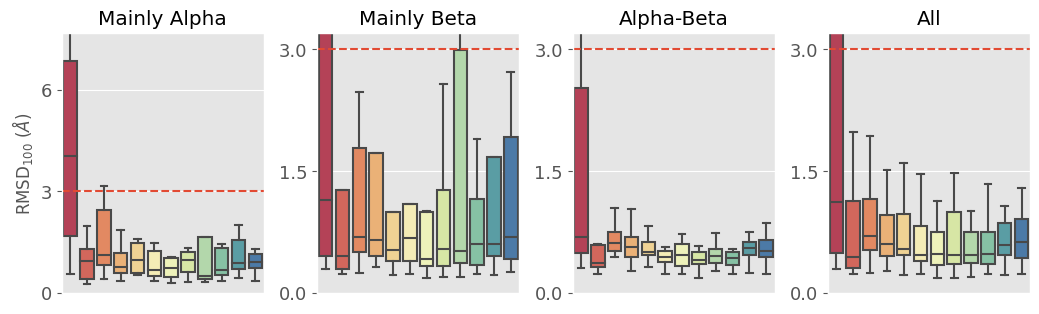

In [22]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_model4_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_rmsd, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.color_palette("Spectral", n_colors=len(model_names)))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('RMSD$_{100}$ ($\AA$)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))
    axes[c-1].axes.xaxis.set_visible(False)
    if c-1 == 0:
        axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    else:
        axes[c-1].set_ylim(ymin=0, ymax=3.2)
    axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

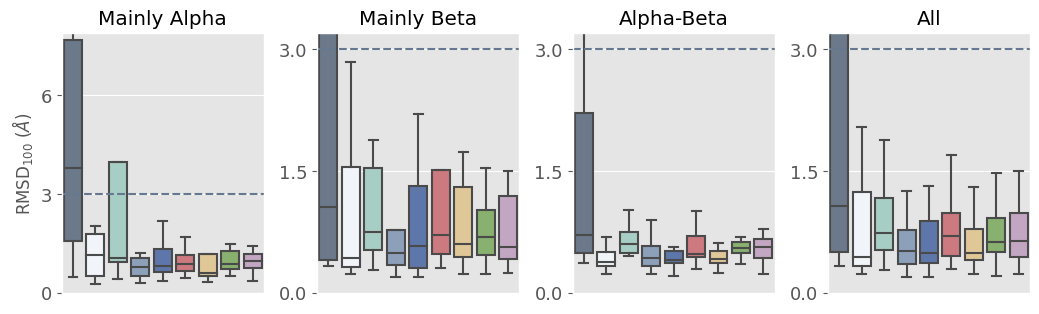

In [281]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_rmsd, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.set_palette(nord_palette))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('RMSD$_{100}$ ($\AA$)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))
    axes[c-1].axes.xaxis.set_visible(False)
    if c-1 == 0:
        axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    else:
        axes[c-1].set_ylim(ymin=0, ymax=3.2)
    axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

# RSMD Correlations

In [11]:
from pathlib import Path
path_to_correlations = Path("/scratch/af2_model-comparison/publication_uncertainty/analysis/")
pack_density_mode = "backbone"
path_to_correlations = path_to_correlations / pack_density_mode
path_to_correlations

PosixPath('/scratch/af2_model-comparison/publication_uncertainty/analysis/backbone')

In [12]:
results_arr = []
columns = [
    "model",
    "pdb",
    "n",
    "temp",
    "seq_accuracy",
    "curr_entropy_mean",
    "curr_entropy_std",
    "curr_packdensity_mean",
    "curr_packdensity_std",
    "real_packdensity_mean",
    "real_packdensity_std",
    "curr_bfactor_mean",
    "curr_bfactor_std",
    "curr_rmsd",
]
for curr_model in [
    "TIMED",
    "TIMED-Deep",

]:
    curr_model_path = path_to_correlations / f"all_results_{curr_model}-{pack_density_mode}.csv"
    assert curr_model_path.exists(), f"Input file {curr_model_path} does not exist"
    # Load results in pandas:
    df = pd.read_csv(curr_model_path, header=None)
    df.dropna(inplace=True)
    results_arr += df.values.tolist()
# Merge all together:
results_arr = pd.DataFrame(results_arr, columns=columns)

In [13]:
results_arr.pdb =  results_arr.pdb.str.lstrip()
np.savetxt('temp_structures.txt', results_arr.pdb.unique(), delimiter='\n', fmt='%s')
temp_df = get_cath.filter_with_user_list(cath_df, 'temp_structures.txt')
temp_df.head()

,PDB,chain,class,architecture,topology,hsf,start,stop
63148,1h32,A,1,10,760,10,1,54
71296,1dvo,A,1,10,1710,10,33,184
86819,1a41,A,1,20,120,380,217,310
112599,1gxm,A,1,50,10,20,326,649
113522,1bx7,A,2,10,22,10,3,53


### Add class to structure

In [14]:
for pdb_code in temp_df.PDB.unique():
    results_arr.loc[results_arr['pdb']==f"{pdb_code}A",'class'] = int(temp_df[temp_df['PDB']==pdb_code]['class'])
results_arr['seq_accuracy'] = results_arr['seq_accuracy'].mul(100)

results_arr.head()

,model,pdb,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
0,TIMED,1jdwA,18,0.2,34.166667,3.678318,0.844525,63.186458,11.135536,67.227083,11.347349,87.245694,9.795477,1.509934,3.0
1,TIMED,1lpbA,3,1.0,23.529412,3.424297,1.308312,45.591176,9.434534,63.197059,13.325898,44.817059,10.457472,7.529862,2.0
2,TIMED,1dqgA,13,0.2,35.074627,3.663910,0.840007,62.206157,15.618695,62.215485,14.357699,75.300448,11.440927,1.212395,2.0
3,TIMED,1j5uA,11,0.6,33.070866,3.747375,0.813293,50.761811,13.660414,63.087598,13.065621,39.447795,11.398768,6.419654,3.0
4,TIMED,1muwA,8,0.2,36.269430,3.688190,0.852348,61.011010,12.753684,65.497409,12.341737,89.540052,7.222578,1.713842,3.0


In [15]:
results_arr.loc[results_arr['model']=="TIMED-Deep", "model"] = "TIMED_Deep"
results_arr.sort_values(by="model", inplace=True)

## Confidence of sequence model from entropy

### Accuracy vs RMSD

In [16]:
def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio *2

    return fig_width_in, fig_height_in



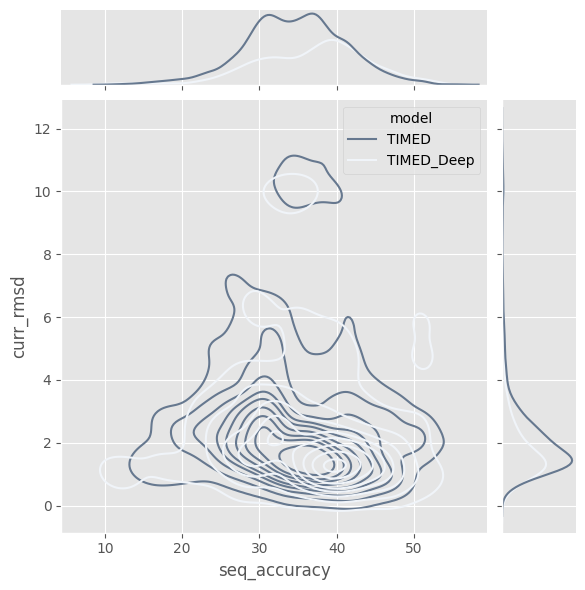

In [132]:
sns.jointplot(data=results_arr[(results_arr['temp']==0.2)], x="seq_accuracy", y="curr_rmsd", hue="model", legend=True, kind='kde')

In [265]:
model_names

['evoEF2',
 'rosetta',
 'prodconn',
 'DenseNet',
 'densecpd',
 'timed',
 'timed_deep',
 'TIMED_polar_fix',
 'TIMED_charge']

In [267]:
results_arr['class'].unique()

array([3., 2., 1., 4.])

In [17]:
# Export all correlations
from scipy.stats import pearsonr
XY_pairs = [("seq_accuracy", "curr_rmsd"), ("curr_entropy_mean", "curr_rmsd"), ("real_packdensity_mean", "seq_accuracy"),("real_packdensity_mean", "curr_entropy_mean"),("real_packdensity_mean", "curr_rmsd")]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta"]
results_corr = []

for selected_x, selected_y in XY_pairs:
    for model in results_arr['model'].unique():
        # All temperatures and all folds:
        curr_x = results_arr[(results_arr['model']==model)][selected_x]
        curr_y = results_arr[(results_arr['model']==model)][selected_y]
        results_corr.append([model, 'All', 'All', selected_x, selected_y, *pearsonr(curr_x,curr_y)])
        # All folds
        for t in results_arr['temp'].unique():
            # Per fold:
            for i, fold in enumerate(class_names):
                curr_x = results_arr[(results_arr['temp']==t) & (results_arr['class']==i+1) & (results_arr['model']==model)][selected_x]
                curr_y = results_arr[(results_arr['temp']==t) & (results_arr['class']==i+1) & (results_arr['model']==model)][selected_y]
                results_corr.append([model, fold, t,selected_x, selected_y, *pearsonr(curr_x,curr_y)])
results = pd.DataFrame(results_corr).to_markdown(index=False)
print(results)



/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


| 0          | 1            | 2   | 3                     | 4                 |             5 |              6 |
|:-----------|:-------------|:----|:----------------------|:------------------|--------------:|---------------:|
| TIMED      | All          | All | seq_accuracy          | curr_rmsd         |  -0.56797     |   0            |
| TIMED      | Mainly Alpha | 0.2 | seq_accuracy          | curr_rmsd         |  -0.595841    |   2.52517e-39  |
| TIMED      | Mainly Beta  | 0.2 | seq_accuracy          | curr_rmsd         |  -0.124207    |   6.84963e-11  |
| TIMED      | Alpha-Beta   | 0.2 | seq_accuracy          | curr_rmsd         |  -0.481453    |   2.79076e-116 |
| TIMED      | Mainly Alpha | 1.0 | seq_accuracy          | curr_rmsd         |  -0.37723     |   5.65311e-15  |
| TIMED      | Mainly Beta  | 1.0 | seq_accuracy          | curr_rmsd         |  -0.407154    |   7.5916e-115  |
| TIMED      | Alpha-Beta   | 1.0 | seq_accuracy          | curr_rmsd         |  -0.479247    | 

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


AttributeError: 'Line2D' object has no property 'edgecolor'

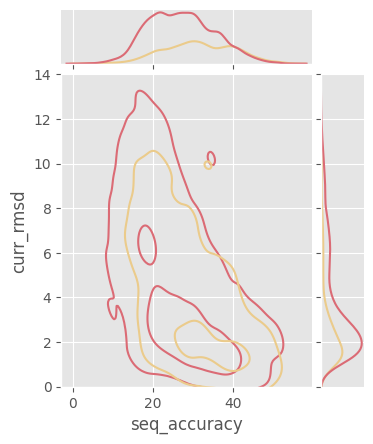

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
# Set the figure size
pal = sns.color_palette("Spectral", n_colors=len(model_names))
palette = nord_palette
new_palette = [pal[0], pal[3]]
# Create the jointplot
g = sns.jointplot(data=results_arr, x="seq_accuracy", y="curr_rmsd", hue="model", legend=False, kind='kde', palette=palette[5:], n_levels=3, ylim=(0, 14))
g.fig.set_size_inches(set_size(505.89*0.5))
# Iterate over each model and add a line of best fit
for i, model in enumerate(results_arr['model'].unique()):
    # Filter the data for the current model
    model_data = results_arr[(results_arr['temp']==0.2) & (results_arr['model']==model)]
    
    # Add the line of best fit
    sns.regplot(data=model_data, x="seq_accuracy", y="curr_rmsd", scatter=False, color=new_palette[i],  ax=g.ax_joint, line_kws={'linewidth':5, 'edgecolor': 'black'})

# Set x and y labels
g.ax_joint.set_xlabel("Accuracy (%)",  fontsize=14)
g.ax_joint.set_ylabel(r"RMSD ($\AA$)",  fontsize=14)
g.ax_joint.tick_params(axis='both', which='both', labelsize=13)


# Set the legend title and labels
plt.tight_layout()
plt.savefig(f"rmsdvsaccuracy.pdf", bbox_inches='tight', dpi=300)
# Show the plot
plt.show()


,model,pdb,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
0,TIMED,1jdwA,18,0.2,34.166667,3.678318,0.844525,63.186458,11.135536,67.227083,11.347349,87.245694,9.795477,1.509934,3.0
10725,TIMED,1jofA,18,1.0,18.082192,3.615823,0.846939,47.448630,14.081618,67.232877,12.681753,31.735342,8.164679,5.505128,2.0
10726,TIMED,1jovA,11,0.6,24.535316,3.757612,0.800340,62.976766,12.846912,67.093866,11.911091,86.522491,9.929447,1.468143,2.0
10727,TIMED,1genA,12,0.2,29.500000,3.745350,0.753623,59.120625,13.622439,63.223125,14.654425,88.632400,7.692256,1.941511,2.0
10728,TIMED,1genA,3,1.0,17.000000,3.745350,0.753623,47.938125,11.704032,63.223125,14.654425,34.682250,7.558033,9.217260,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18376,TIMED_Deep,1j3aA,8,0.2,40.310078,3.524370,0.969991,59.642442,11.855372,61.991279,11.313368,91.083953,8.717826,0.905026,3.0
18375,TIMED_Deep,1igqA,15,0.6,14.814815,3.736914,0.658772,36.557870,8.573036,61.497685,13.034176,61.874074,7.825935,8.027874,2.0
18374,TIMED_Deep,1muwA,9,0.6,31.088083,3.500520,1.022110,60.259715,12.652950,65.497409,12.341737,80.536347,12.772192,2.181285,3.0
18372,TIMED_Deep,1kcfA,17,0.6,25.416667,3.802885,0.562491,59.874479,11.326071,62.054688,12.837423,78.955750,12.795936,3.852104,3.0


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


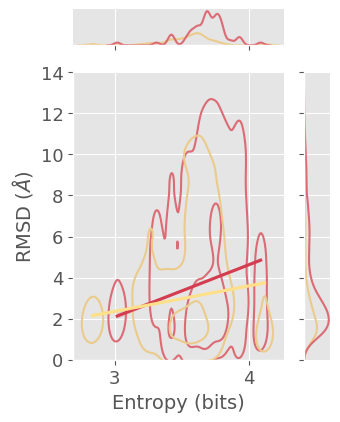

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size

# Create the jointplot
g = sns.jointplot(data=results_arr, x="curr_entropy_mean", y="curr_rmsd", hue="model", legend=False, kind='kde', palette=palette[5:], n_levels=3, ylim=(0, 14))
g.fig.set_size_inches(set_size(505.89*0.5))
# Iterate over each model and add a line of best fit
for i, model in enumerate(results_arr['model'].unique()):
    # Filter the data for the current model
    model_data = results_arr[(results_arr['model']==model)]
    
    # Add the line of best fit
    sns.regplot(data=model_data, x="curr_entropy_mean", y="curr_rmsd", scatter=False, color=new_palette[i],  ax=g.ax_joint)

# Set x and y labels
g.ax_joint.set_xlabel("Entropy (bits)",  fontsize=14)
g.ax_joint.set_ylabel(r"RMSD ($\AA$)",  fontsize=14)
g.ax_joint.tick_params(axis='both', which='both', labelsize=13)
# Set the legend title and labels
plt.tight_layout()

plt.savefig(f"rmsdvsentropy.pdf",bbox_inches='tight', dpi=300)
# Show the plot
# Show the plot
plt.show()


## PAcking density

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


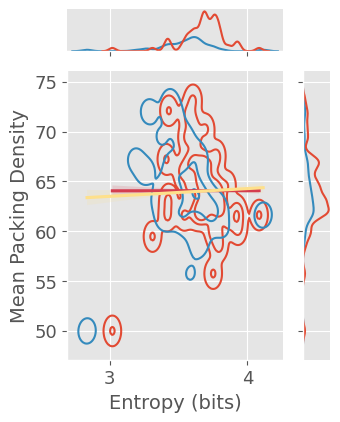

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3]]

# Create the jointplot
g = sns.jointplot(data=results_arr, x="curr_entropy_mean", y="real_packdensity_mean", hue="model", legend=False, kind='kde', n_levels=4)
g.fig.set_size_inches(set_size(505.89*0.5))
# Iterate over each model and add a line of best fit
for i, model in enumerate(results_arr['model'].unique()):
    # Filter the data for the current model
    model_data = results_arr[(results_arr['model']==model)]
    
    # Add the line of best fit
    sns.regplot(data=model_data, x="curr_entropy_mean", y="real_packdensity_mean", scatter=False, color=new_palette[i],  ax=g.ax_joint)

# Set x and y labels
g.ax_joint.set_xlabel("Entropy (bits)",  fontsize=14)
g.ax_joint.set_ylabel("Mean Packing Density",  fontsize=14)
g.ax_joint.tick_params(axis='both', which='both', labelsize=13)

# Set the legend title and labels
# Set the legend title and labels
plt.tight_layout()
plt.savefig(f"densityvsentropy.pdf",bbox_inches='tight', dpi=300)
# Show the plot
plt.show()


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


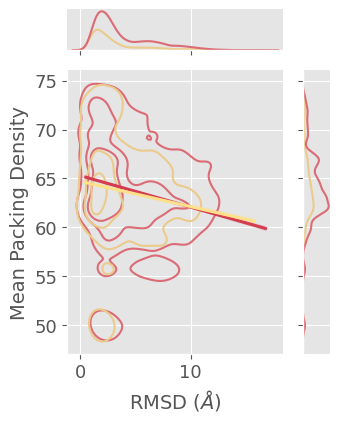

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3]]

# Create the jointplot
g = sns.jointplot(data=results_arr, x="curr_rmsd", y="real_packdensity_mean", hue="model", legend=False, kind='kde', palette=nord_palette[5:], n_levels=4)
g.fig.set_size_inches(set_size(505.89*0.5))
# Iterate over each model and add a line of best fit
for i, model in enumerate(results_arr['model'].unique()):
    # Filter the data for the current model
    model_data = results_arr[(results_arr['model']==model)]
    
    # Add the line of best fit
    sns.regplot(data=model_data, x="curr_rmsd", y="real_packdensity_mean", scatter=False, color=new_palette[i],  ax=g.ax_joint)

# Set x and y labels
g.ax_joint.set_xlabel("RMSD ($\AA$)",  fontsize=14)
g.ax_joint.set_ylabel("Mean Packing Density",  fontsize=14)
g.ax_joint.tick_params(axis='both', which='both', labelsize=13)

# Set the legend title and labels
plt.tight_layout()
plt.savefig(f"densityvsrmsd.pdf",bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


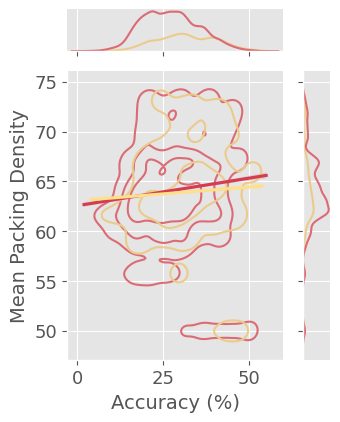

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3]]

# Create the jointplot
g = sns.jointplot(data=results_arr, x="seq_accuracy", y="real_packdensity_mean", hue="model", legend=False, kind='kde', palette=palette[5:], n_levels=4)
g.fig.set_size_inches(set_size(505.89*0.5))
# Iterate over each model and add a line of best fit
for i, model in enumerate(results_arr['model'].unique()):
    # Filter the data for the current model
    model_data = results_arr[(results_arr['model']==model)]
    
    # Add the line of best fit
    sns.regplot(data=model_data, x="seq_accuracy", y="real_packdensity_mean", scatter=False, color=new_palette[i],  ax=g.ax_joint)

# Set x and y labels
g.ax_joint.set_xlabel("Accuracy (%)",  fontsize=14)
g.ax_joint.set_ylabel("Mean Packing Density",  fontsize=14)
g.ax_joint.tick_params(axis='both', which='both', labelsize=13)

# Set the legend title and labels
plt.tight_layout()
plt.savefig(f"densityvaccuracy.pdf",bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


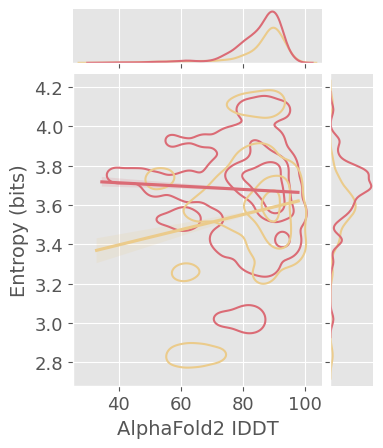

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size

# Create the jointplot
g = sns.jointplot(data=results_arr[(results_arr['temp']==0.2)], x="curr_bfactor_mean", y="curr_entropy_mean", hue="model", legend=False, kind='kde', palette=palette[5:], n_levels=4)
g.fig.set_size_inches(set_size(505.89*0.5))
# Iterate over each model and add a line of best fit
for i, model in enumerate(results_arr['model'].unique()):
    # Filter the data for the current model
    model_data = results_arr[(results_arr['temp']==0.2) & (results_arr['model']==model)]
    
    # Add the line of best fit
    sns.regplot(data=model_data, x="curr_bfactor_mean", y="curr_entropy_mean", scatter=False, color=palette[5:][i],  ax=g.ax_joint)

# Set x and y labels
g.ax_joint.set_xlabel("AlphaFold2 IDDT",  fontsize=14)
g.ax_joint.set_ylabel(r"Entropy (bits)",  fontsize=14)
g.ax_joint.tick_params(axis='both', which='both', labelsize=13)

# Set the legend title and labels

# Show the plot
plt.show()


# OLD

Text(0.5, -0.04, 'RMSD ($\\AA$)')

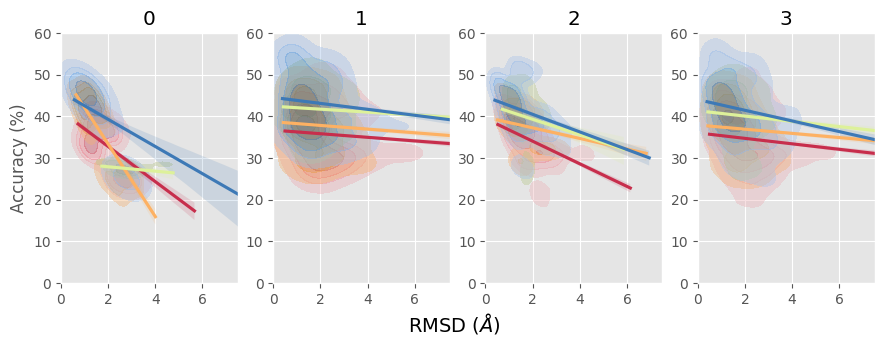

In [99]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
results_corr = []
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "seq_accuracy"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    curr_ax.set_xlim(0, 7.5)
    curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Accuracy (%)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

Text(0.5, -0.04, 'RMSD ($\\AA$)')

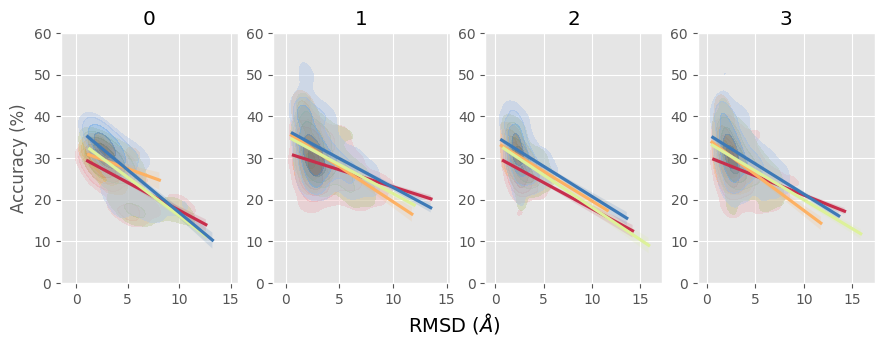

In [101]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "seq_accuracy"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_xlim(0, 7.5)
    curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Accuracy (%)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

Text(0.5, -0.04, 'RMSD ($\\AA$)')

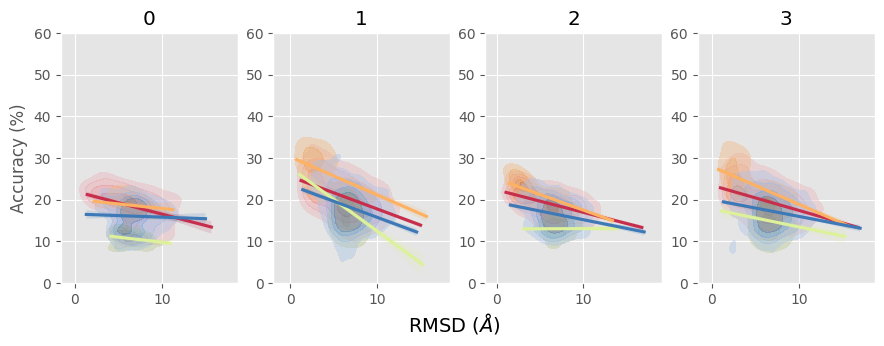

In [102]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "seq_accuracy"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1.0)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_xlim(0, 7.5)
    curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Accuracy (%)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

In [24]:
pd.DataFrame(results_corr)

,0,1,2,3,4,5,6
0,TIMED,All,All,seq_accuracy,curr_rmsd,-0.567970,0.000000e+00
1,TIMED,Mainly Alpha,0.2,seq_accuracy,curr_rmsd,-0.595841,2.525174e-39
2,TIMED,Mainly Beta,0.2,seq_accuracy,curr_rmsd,-0.124207,6.849630e-11
3,TIMED,Alpha-Beta,0.2,seq_accuracy,curr_rmsd,-0.481453,2.790763e-116
4,TIMED,Mainly Alpha,1.0,seq_accuracy,curr_rmsd,-0.377230,5.653113e-15
...,...,...,...,...,...,...,...
95,TIMED_Deep,Mainly Beta,1.0,real_packdensity_mean,curr_rmsd,-0.175610,2.571234e-07
96,TIMED_Deep,Alpha-Beta,1.0,real_packdensity_mean,curr_rmsd,-0.559973,9.175408e-65
97,TIMED_Deep,Mainly Alpha,0.6,real_packdensity_mean,curr_rmsd,-0.739474,4.387902e-28
98,TIMED_Deep,Mainly Beta,0.6,real_packdensity_mean,curr_rmsd,-0.097301,2.479239e-03


In [33]:
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'selected_x', 'selected_y', 'pearson', 'p-value'])
pearson_df

,model,fold,temp,selected_x,selected_y,pearson,p-value
0,TIMED,All,All,seq_accuracy,curr_rmsd,-0.567970,0.000000e+00
1,TIMED,Mainly Alpha,0.2,seq_accuracy,curr_rmsd,-0.595841,2.525174e-39
2,TIMED,Mainly Beta,0.2,seq_accuracy,curr_rmsd,-0.124207,6.849630e-11
3,TIMED,Alpha-Beta,0.2,seq_accuracy,curr_rmsd,-0.481453,2.790763e-116
4,TIMED,Mainly Alpha,1.0,seq_accuracy,curr_rmsd,-0.377230,5.653113e-15
...,...,...,...,...,...,...,...
95,TIMED_Deep,Mainly Beta,1.0,real_packdensity_mean,curr_rmsd,-0.175610,2.571234e-07
96,TIMED_Deep,Alpha-Beta,1.0,real_packdensity_mean,curr_rmsd,-0.559973,9.175408e-65
97,TIMED_Deep,Mainly Alpha,0.6,real_packdensity_mean,curr_rmsd,-0.739474,4.387902e-28
98,TIMED_Deep,Mainly Beta,0.6,real_packdensity_mean,curr_rmsd,-0.097301,2.479239e-03


#### Accuracy vs RMSD correlation at different temperatures

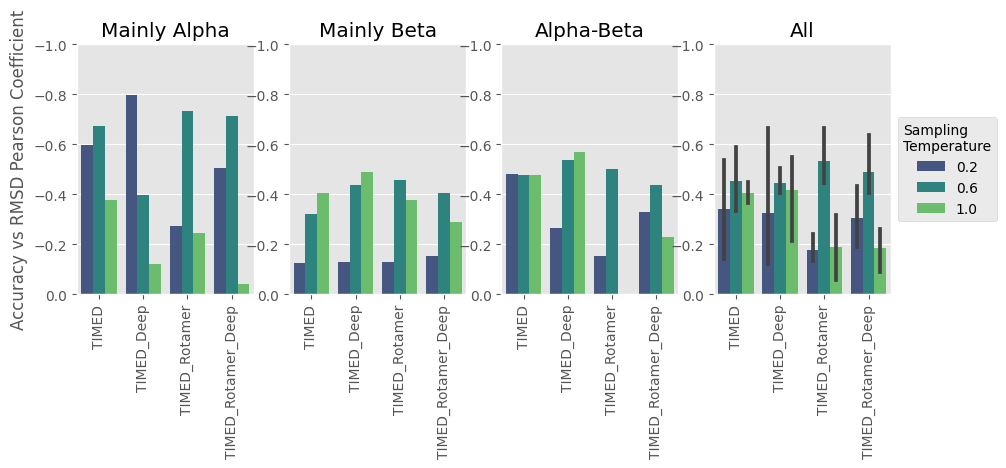

In [128]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "seq_accuracy"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(0, -1)
    if i==0:
        curr_ax.set_ylabel("Accuracy vs RMSD Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")


### Entropy vs RMSD

In [175]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1) & (results_arr['model']=='TIMED') ].groupby('pdb').mean()

,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
pdb,,,,,,,,,,,,,
1a41A,10.0,0.2,24.482020,3.932107,0.496808,60.582895,11.409804,60.153281,11.625747,80.991683,9.203062,2.913859,1.0
1dvoA,9.5,0.2,37.269737,3.797704,0.685363,57.372434,9.095060,62.264803,9.892732,91.021133,4.864580,1.730742,1.0
1gxmA,9.5,0.2,37.731481,3.696182,0.786810,63.080656,12.280862,70.245370,12.220907,88.338384,9.340874,1.711042,1.0
1h32A,9.5,0.2,32.681992,3.568738,1.022330,62.065053,11.847820,71.750000,10.425117,91.239930,8.079230,1.331775,1.0


In [167]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=='TIMED') ].groupby('pdb').mean()

,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
pdb,,,,,,,,,,,,,
1b77A,9.5,0.2,29.736842,3.795664,0.672043,59.519967,12.097202,62.366776,10.940040,89.517711,6.197909,1.646709,3.0
1chdA,9.5,0.2,32.828283,3.691766,0.854781,59.318176,11.945804,64.369318,11.235887,80.589844,13.428156,2.072516,3.0
1dmlA,9.5,0.2,30.786517,3.773809,0.787961,59.152331,12.951985,59.614232,12.481543,78.491354,9.896764,2.531011,3.0
1ds1A,9.5,0.2,37.476780,3.690801,0.792201,61.040813,11.767761,66.320046,11.658028,89.264170,9.248244,1.299500,3.0
1ejdA,9.5,0.2,41.682578,3.571944,0.963070,60.159212,10.531151,66.789379,9.765777,89.150893,10.477120,1.664454,3.0
1ewfA,9.5,0.2,31.414474,3.761759,0.774982,60.588775,11.750875,63.801535,11.231656,87.498845,7.436307,3.099880,3.0
1g61A,9.5,0.2,41.822222,3.560996,0.900330,62.349150,10.663899,69.420000,8.180999,95.647148,3.334132,0.760857,3.0
1h70A,9.5,0.2,34.862745,3.707420,0.731650,60.412064,11.117658,64.187745,11.434800,88.954685,6.721533,1.535829,3.0
1hq0A,9.5,0.2,36.372881,3.651237,0.914351,62.876322,12.783085,65.350847,12.928826,88.022235,9.332515,1.651684,3.0


In [166]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==2) & (results_arr['model']=='TIMED') ].groupby('pdb').mean()

,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
pdb,,,,,,,,,,,,,
1b2pA,9.5,0.2,29.369748,3.686873,0.760758,55.293561,13.780935,66.403361,11.840418,66.546813,12.766564,3.016430,2.0
1b8kA,9.5,0.2,26.166667,3.750905,0.855689,49.716861,11.816029,55.738889,12.718133,58.680052,9.052641,4.575382,2.0
1bx7A,9.5,0.2,49.019608,3.018362,1.465980,46.570172,13.185066,49.982843,12.118113,78.569735,9.583296,2.123245,2.0
1c3mA,9.5,0.2,41.241379,3.419023,1.207909,60.120190,13.676105,61.526724,13.761141,92.815360,7.791290,1.340328,2.0
1cruA,9.5,0.2,37.209821,3.625772,0.895200,63.273359,13.308834,69.165737,13.335423,90.049759,7.234684,1.294661,2.0
1dqgA,9.5,0.2,35.111940,3.663910,0.840007,61.706894,14.825128,62.215485,14.357699,82.445128,10.444192,1.358264,2.0
1flgA,9.5,0.2,34.613402,3.672109,0.858193,65.082234,13.343087,64.830326,12.846446,85.545362,8.721307,1.579342,2.0
1g3pA,9.5,0.2,41.562500,3.525587,1.005590,55.584219,14.237991,65.966797,13.327717,67.305681,17.939669,5.101178,2.0
1genA,9.5,0.2,28.950000,3.745350,0.753623,58.862856,12.912342,63.223125,14.654425,83.371724,9.761484,2.027664,2.0


In [170]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1) & (results_arr['model']=='TIMED') ].groupby('pdb').mean()

,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
pdb,,,,,,,,,,,,,
1a41A,10.0,0.2,24.482020,3.932107,0.496808,60.582895,11.409804,60.153281,11.625747,80.991683,9.203062,2.913859,1.0
1dvoA,9.5,0.2,37.269737,3.797704,0.685363,57.372434,9.095060,62.264803,9.892732,91.021133,4.864580,1.730742,1.0
1gxmA,9.5,0.2,37.731481,3.696182,0.786810,63.080656,12.280862,70.245370,12.220907,88.338384,9.340874,1.711042,1.0
1h32A,9.5,0.2,32.681992,3.568738,1.022330,62.065053,11.847820,71.750000,10.425117,91.239930,8.079230,1.331775,1.0


In [172]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)].groupby(['model','pdb']).mean()

n  temp  seq_accuracy  curr_entropy_mean  \
model              pdb                                                       
TIMED              1a41A  10.000000   0.2     24.482020           3.932107   
                   1dvoA   9.500000   0.2     37.269737           3.797704   
                   1gxmA   9.500000   0.2     37.731481           3.696182   
                   1h32A   9.500000   0.2     32.681992           3.568738   
TIMED_Deep         1a41A  10.000000   0.2     24.839247           3.825517   
                   1gxmA   9.500000   0.2     42.716049           3.510478   
                   1h32A   9.500000   0.2     40.900383           3.460131   
TIMED_Rotamer      1a41A  12.333333   0.2     27.413273           7.693652   
TIMED_Rotamer_Deep 1a41A  10.000000   0.2     25.196475           7.599647   
                   1dvoA   9.500000   0.2     40.164474           7.416673   
                   1gxmA   9.500000   0.2     45.462963           7.118610   
                   1h32A   9.500000   0.2     46.781609           7.086000   

                          curr_entropy_std  curr_packdensity_mean  \
model              pdb                                              
TIMED              1a41A          0.496808              60.582895   
                   1dvoA          0.685363              57.372434   
                   1gxmA          0.786810              63.080656   
                   1h32A          1.022330              62.065053   
TIMED_Deep         1a41A          0.567404              61.821839   
                   1gxmA          0.931272              63.685926   
                   1h32A          1.108047              62.370144   
TIMED_Rotamer      1a41A          0.570011              57.634908   
TIMED_Rotamer_Deep 1a41A          0.823634              57.376387   
                   1dvoA          1.182971              53.202944   
                   1gxmA          1.586879              60.568696   
                   1h32A          1.703922              59.153190   

                          curr_packdensity_std  real_packdensity_mean  \
model              pdb                                                  
TIMED              1a41A             11.409804              60.153281   
                   1dvoA              9.095060              62.264803   
                   1gxmA             12.280862              70.245370   
                   1h32A             11.847820              71.750000   
TIMED_Deep         1a41A             11.045961              60.153281   
                   1gxmA             12.364745              70.245370   
                   1h32A             11.713513              71.750000   
TIMED_Rotamer      1a41A             11.473265              60.153281   
TIMED_Rotamer_Deep 1a41A             11.144154              60.153281   
                   1dvoA              9.739864              62.264803   
                   1gxmA             12.611167              70.245370   
                   1h32A             11.617751              71.750000   

                          real_packdensity_std  curr_bfactor_mean  \
model              pdb                                              
TIMED              1a41A             11.625747          80.991683   
                   1dvoA              9.892732          91.021133   
                   1gxmA             12.220907          88.338384   
                   1h32A             10.425117          91.239930   
TIMED_Deep         1a41A             11.625747          84.043781   
                   1gxmA             12.220907          89.390017   
                   1h32A             10.425117          93.404114   
TIMED_Rotamer      1a41A             11.625747          81.489238   
TIMED_Rotamer_Deep 1a41A             11.625747          79.773718   
                   1dvoA              9.892732          87.845332   
                   1gxmA             12.220907          91.185965   
                   1h32A             10.425117        

### Entropy RMSD

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, -0.04, 'RMSD ($\\AA$)')

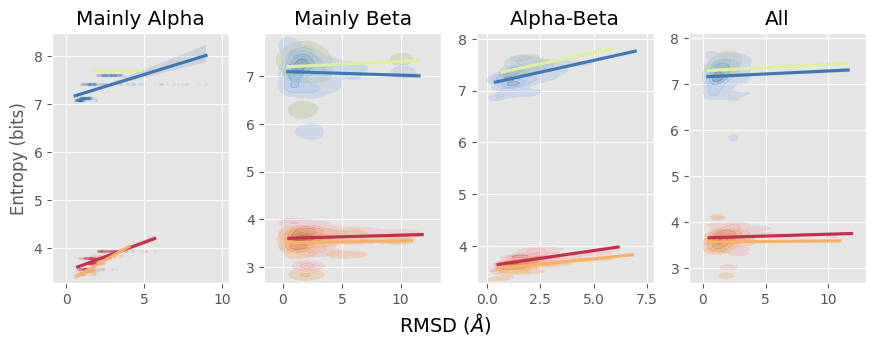

In [224]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
results_corr = []
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = True
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

In [182]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1)][selected_x]

35481    2.916642
35465    2.901474
35487    1.681721
35510    1.193448
35500    2.167086
           ...   
10637    1.260858
10825    1.712024
10754    0.910218
10755    1.827181
10734    1.041201
Name: curr_rmsd, Length: 1145, dtype: float64

In [124]:
sns.jointplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1)], x=selected_x, y=selected_y, hue="model", legend=True, kind='kde'  )

NameError: name 'selected_x' is not defined

Text(0.5, -0.04, 'RMSD ($\\AA$)')

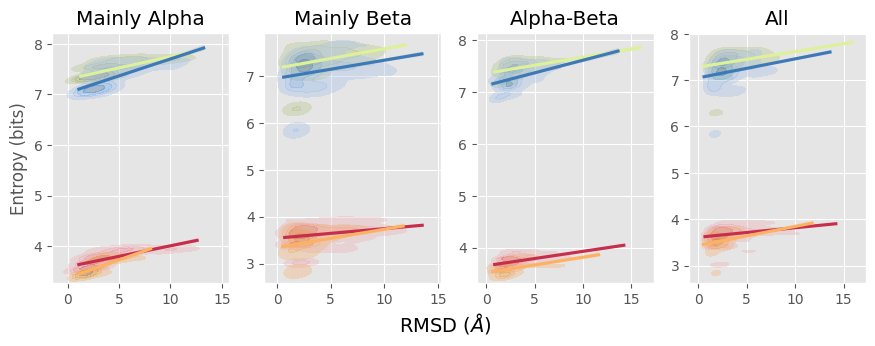

In [225]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = False
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, -0.04, 'RMSD ($\\AA$)')

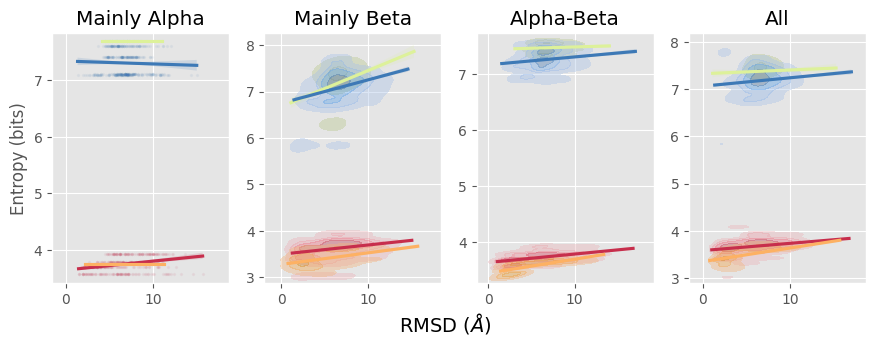

In [226]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = True
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 1, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 1, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

In [27]:
np.array(results_corr)

array([['TIMED', 'All', 'All', 'seq_accuracy', 'curr_rmsd',
        '-0.5679697994532538', '0.0'],
       ['TIMED', 'Mainly Alpha', '0.2', 'seq_accuracy', 'curr_rmsd',
        '-0.5958413081722606', '2.5251738336425453e-39'],
       ['TIMED', 'Mainly Beta', '0.2', 'seq_accuracy', 'curr_rmsd',
        '-0.12420674960060375', '6.849629733903711e-11'],
       ['TIMED', 'Alpha-Beta', '0.2', 'seq_accuracy', 'curr_rmsd',
        '-0.4814529527703782', '2.7907633858529123e-116'],
       ['TIMED', 'Mainly Alpha', '1.0', 'seq_accuracy', 'curr_rmsd',
        '-0.37723018058312335', '5.653113141693959e-15'],
       ['TIMED', 'Mainly Beta', '1.0', 'seq_accuracy', 'curr_rmsd',
        '-0.4071540061203742', '7.591602569433752e-115'],
       ['TIMED', 'Alpha-Beta', '1.0', 'seq_accuracy', 'curr_rmsd',
        '-0.4792468059698001', '1.1812834839563648e-115'],
       ['TIMED', 'Mainly Alpha', '0.6', 'seq_accuracy', 'curr_rmsd',
        '-0.6720877057597507', '6.875837163641471e-54'],
       ['TIMED', 

In [20]:
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'pearson', 'p-value'])
pearson_df

ValueError: 5 columns passed, passed data had 7 columns

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


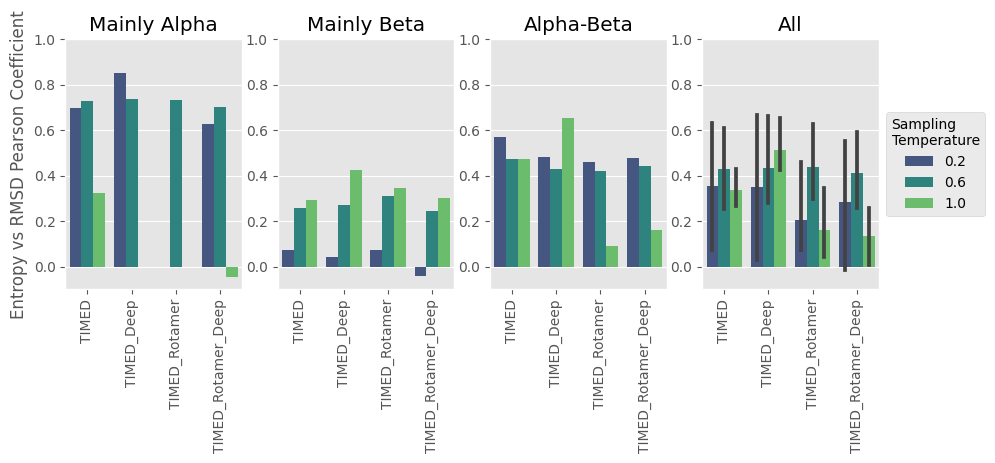

In [231]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(-0.1, 1)
    if i==0:
        curr_ax.set_ylabel("Entropy vs RMSD Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")


In [48]:
pearson_df

,model,fold,temp,selected_x,selected_y,pearson,p-value
0,TIMED,All,All,seq_accuracy,curr_rmsd,-0.567970,0.000000e+00
1,TIMED,Mainly Alpha,0.2,seq_accuracy,curr_rmsd,-0.595841,2.525174e-39
2,TIMED,Mainly Beta,0.2,seq_accuracy,curr_rmsd,-0.124207,6.849630e-11
3,TIMED,Alpha-Beta,0.2,seq_accuracy,curr_rmsd,-0.481453,2.790763e-116
4,TIMED,Mainly Alpha,1.0,seq_accuracy,curr_rmsd,-0.377230,5.653113e-15
...,...,...,...,...,...,...,...
95,TIMED_Deep,Mainly Beta,1.0,real_packdensity_mean,curr_rmsd,-0.175610,2.571234e-07
96,TIMED_Deep,Alpha-Beta,1.0,real_packdensity_mean,curr_rmsd,-0.559973,9.175408e-65
97,TIMED_Deep,Mainly Alpha,0.6,real_packdensity_mean,curr_rmsd,-0.739474,4.387902e-28
98,TIMED_Deep,Mainly Beta,0.6,real_packdensity_mean,curr_rmsd,-0.097301,2.479239e-03


In [65]:
set_size(505.89*1.5)

(10.5, 12.978713763747793)

In [67]:
set_size(505.89)

(7.0, 8.652475842498529)

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


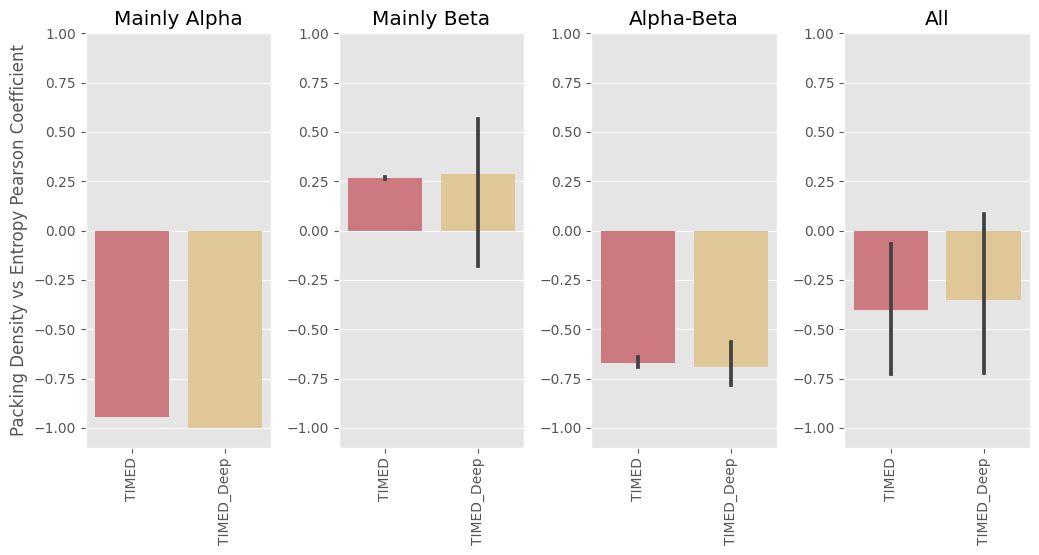

In [81]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
new_palette = [nord_palette[-5], nord_palette[-4]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=(10.5, 5.65), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "real_packdensity_mean"
selected_y = "curr_entropy_mean"

curr_pearson_df = pearson_df[(pearson_df['selected_x']==selected_x) & (pearson_df['selected_y']==selected_y)]


for i, curr_ax in enumerate(axes):
    
    if i < 3:
        sns.barplot(data=curr_pearson_df[curr_pearson_df['fold']==class_names[i]], x="model", y="pearson", palette=new_palette, ax=curr_ax)
        #curr_ax.legend_.remove()
    else:
        sns.barplot(data=curr_pearson_df, x="model", y="pearson",  palette=new_palette, ax=curr_ax)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(-1.1, 1)
    if i==0:
        curr_ax.set_ylabel("Packing Density vs Entropy Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    

# Set the legend title and labels
plt.tight_layout()
plt.savefig(f"densityvsentropy_byfold.pdf",bbox_inches='tight', dpi=300)
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=curr_pearson_df[curr_pearson_df['fold']==0], x="model", y="pearson", hue="temp")


In [114]:
import matplotlib as mpl
from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
g = sns.jointplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3)], x="curr_rmsd", y="seq_accuracy", hue="model",s=14, palette=new_palette, alpha=0.4, marker="+", n_levels=5,  kind="kde", shade=True, )
g.ax_marg_x.set_xlim(0, 10)
g.ax_marg_y.set_ylim(0, 100)
g1 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": new_palette[0]}, ax=g.ax_joint, )
g2 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Deep")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": new_palette[1]}, ax=g.ax_joint)


NameError: name 'results_arr' is not defined

In [ ]:
sns.color_palette("Spectral", n_colors=len(model_names))

In [154]:
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]

In [105]:
sns.color_palette("Spectral", n_colors=len(model_names))[1]

(0.8996539792387543, 0.340715109573241, 0.2848904267589389)

In [110]:
model_names[9]

'timed_rotamer_deep'

AttributeError: 'Line2D' object has no property 'edgecolor'

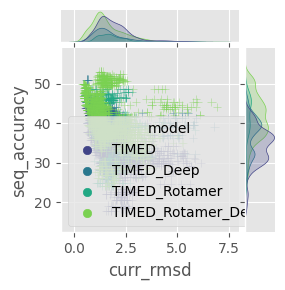

In [12]:
pal = sns.color_palette("viridis", n_colors=4)
g = sns.jointplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3)], x="curr_rmsd", y="seq_accuracy", hue="model", palette="viridis", alpha=0.5, marker="+", height=3)
g1 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": pal[0], "linewidth": 1, "edgecolor": "black"}, ax=g.ax_joint)
g2 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Deep")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": pal[1], "linewidth": 1, "edgecolor": "black"}, ax=g.ax_joint)
g3 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Rotamer")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": pal[2], "linewidth": 1, "edgecolor": "black"}, ax=g.ax_joint)
g4 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Rotamer_Deep")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": pal[3], "linewidth": 1, "edgecolor": "black"}, ax=g.ax_joint)
for ax in g.fig.axes:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

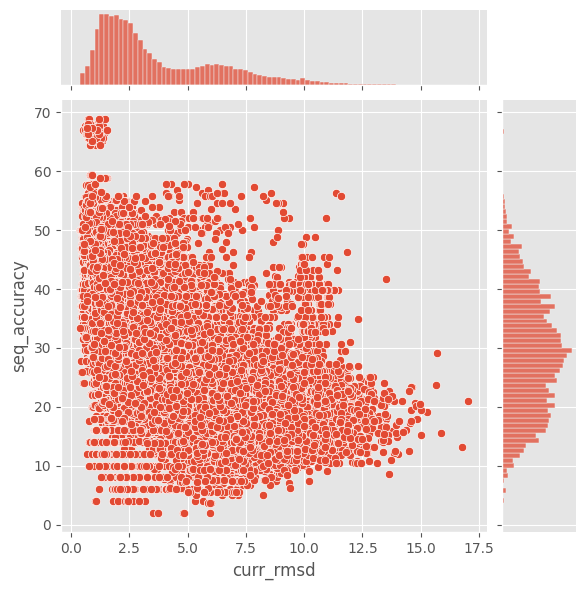

In [14]:
sns.jointplot(data=results_arr, x="curr_rmsd", y="seq_accuracy")

<AxesSubplot:xlabel='curr_rmsd', ylabel='seq_accuracy'>

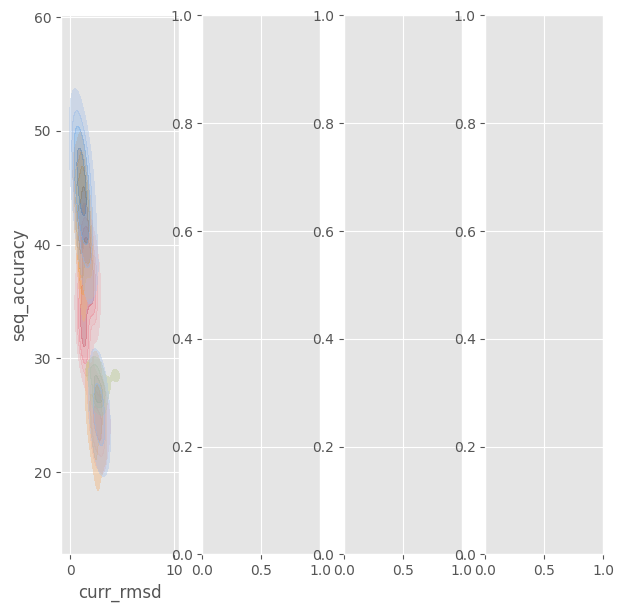

In [19]:
fig, (ax, ax2, ax3, ax4) = plt.subplots(ncols=4)
axes = [ax, ax2, ax3, ax4]
sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1)], x="curr_rmsd", y="seq_accuracy", hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=ax)


In [58]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")].curr_rmsd.to_numpy()

array([1.75642007, 1.02217069, 1.22703454, 1.21982202, 3.93461963,
       2.63767506, 1.29682701, 1.50199084, 0.96828726, 1.1682287 ,
       1.64450181, 4.29989087, 2.22250325, 1.49292751, 0.8822501 ,
       2.70334836, 2.5777452 , 1.14214803, 3.03248549, 2.26865698,
       1.11776607, 1.14140569, 1.48289455, 1.22419038, 1.3123061 ,
       1.25596892, 0.98053992, 1.28942861, 1.52149828, 1.53139387,
       1.11588777, 2.27018308, 2.95497644, 1.65678007, 1.05771441,
       1.12211582, 1.20887831, 0.96669299, 1.29980579, 2.1219798 ,
       3.11978117, 1.48335612, 2.73256976, 1.34180763, 1.26036499,
       0.94059777, 2.75225807, 0.98812667, 1.05246114, 1.68179632,
       2.22280478, 1.81905887, 2.8639531 , 1.21645447, 3.42762488,
       1.34953916, 2.31484975, 2.33186402, 5.23793919, 1.0468637 ,
       1.37741728, 1.14432695, 2.82388098, 1.4816087 , 1.16566882,
       1.23610545, 2.68558629, 2.62026134, 1.11132437, 1.56683641,
       1.35419236, 3.01784667, 0.95249158, 1.25719054, 1.24423

### Entropy vs AF2 confidence

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, -0.04, 'AlphaFold2 IDDt')

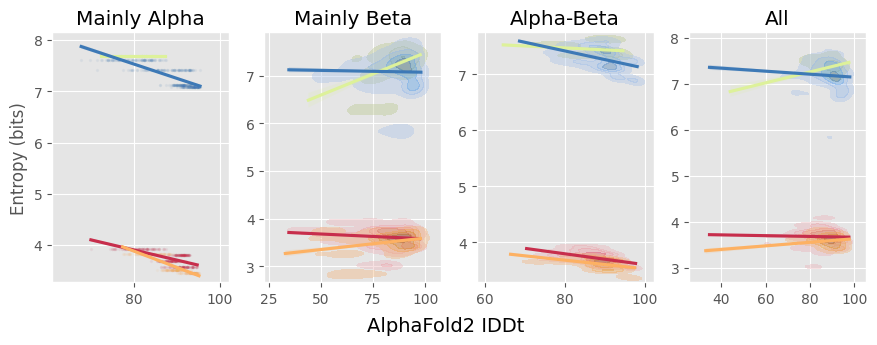

In [243]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
results_corr = []
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_bfactor_mean"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = True
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"AlphaFold2 IDDt", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

Text(0.5, -0.04, 'AlphaFold2 IDDt')

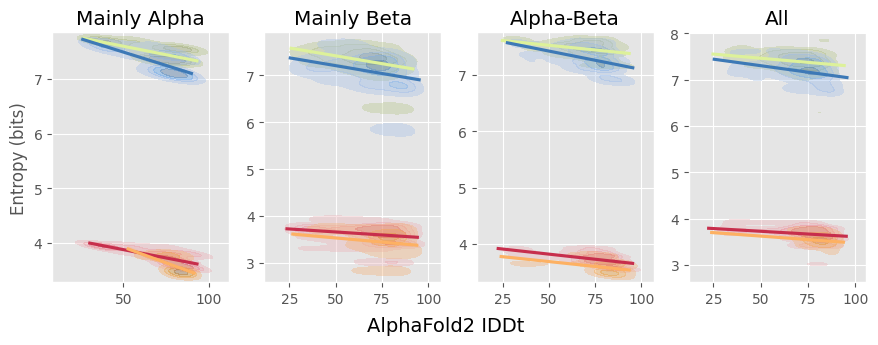

In [244]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_bfactor_mean"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = False
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"AlphaFold2 IDDt", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, -0.04, 'AlphaFold2 IDDt')

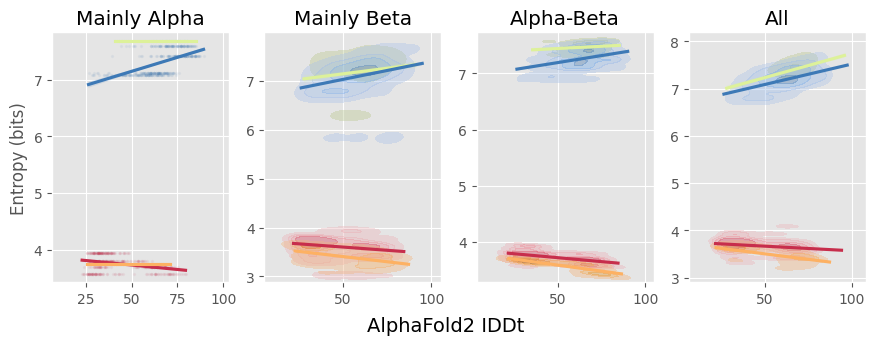

In [245]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_bfactor_mean"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = True
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1.0)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
        #axes[c-1].axhline(3,  ls='--')

    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"AlphaFold2 IDDt", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

In [246]:
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'pearson', 'p-value'])
pearson_df

,model,fold,temp,pearson,p-value
0,TIMED,0,0.2,-0.688717,7.674844e-57
1,TIMED_Deep,0,0.2,-0.845830,6.018358e-82
2,TIMED_Rotamer,0,0.2,NaN,NaN
3,TIMED_Rotamer_Deep,0,0.2,-0.801351,9.975378e-90
4,TIMED,1,0.2,-0.119032,4.101542e-10
5,TIMED_Deep,1,0.2,0.283556,1.002818e-34
6,TIMED_Rotamer,1,0.2,0.442788,2.887374e-49
7,TIMED_Rotamer_Deep,1,0.2,-0.023813,2.061720e-01
8,TIMED,2,0.2,-0.483338,2.621076e-117
9,TIMED_Deep,2,0.2,-0.417692,1.697911e-43


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


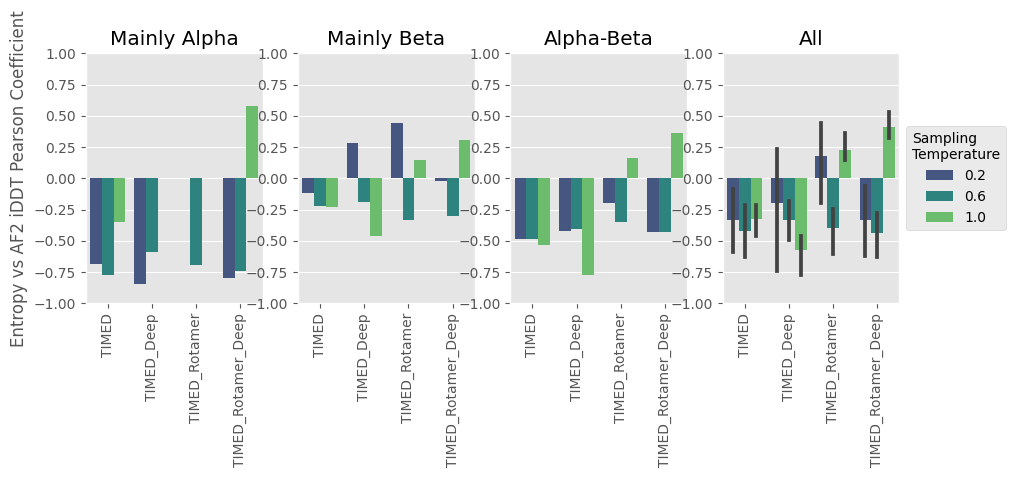

In [251]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_bfactor_mean"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(-1, 1)
    if i==0:
        curr_ax.set_ylabel("Entropy vs AF2 iDDT Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")


### RMSD vs Packing Density

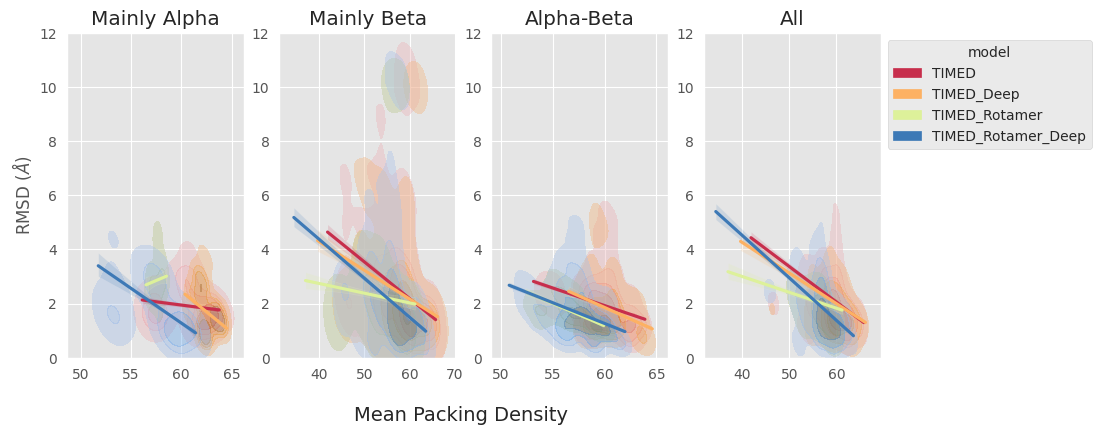

In [193]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
results_corr = []
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_packdensity_mean"
selected_y = "curr_rmsd"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = False
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2)], x=selected_x, y=selected_y, hue="model", legend=True, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        #curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel(r"RMSD ($\AA$)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_ylim(ymin=0, ymax=12)
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r'Mean Packing Density', ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)
sns.move_legend(ax4, "upper left", bbox_to_anchor=(1, 1))

#plt.show()

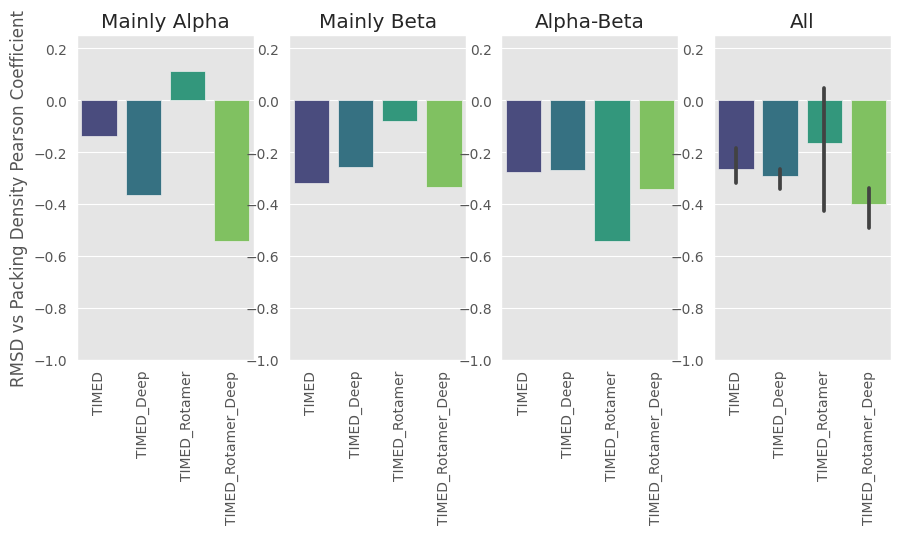

In [194]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'pearson', 'p-value'])
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", palette="viridis", ax=curr_ax)
        #curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson",  palette="viridis", ax=curr_ax)
        #curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(-1, 0.25)
    if i==0:
        curr_ax.set_ylabel("RMSD vs Packing Density Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")


In [195]:
pearson_df.to_csv('1rmsd_packing_density.csv')

### Entropy vs packing density

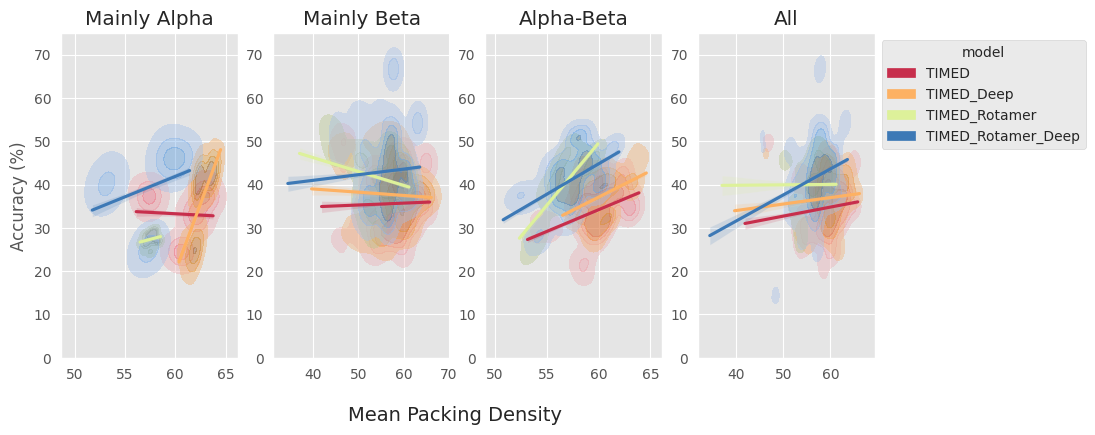

In [196]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
results_corr = []

class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_packdensity_mean"
selected_y = "seq_accuracy"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = False
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2)], x=selected_x, y=selected_y, hue="model", legend=True, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        #curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Accuracy (%)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_ylim(ymin=0, ymax=75)

    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r'Mean Packing Density', ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)
sns.move_legend(ax4, "upper left", bbox_to_anchor=(1, 1))

#plt.show()

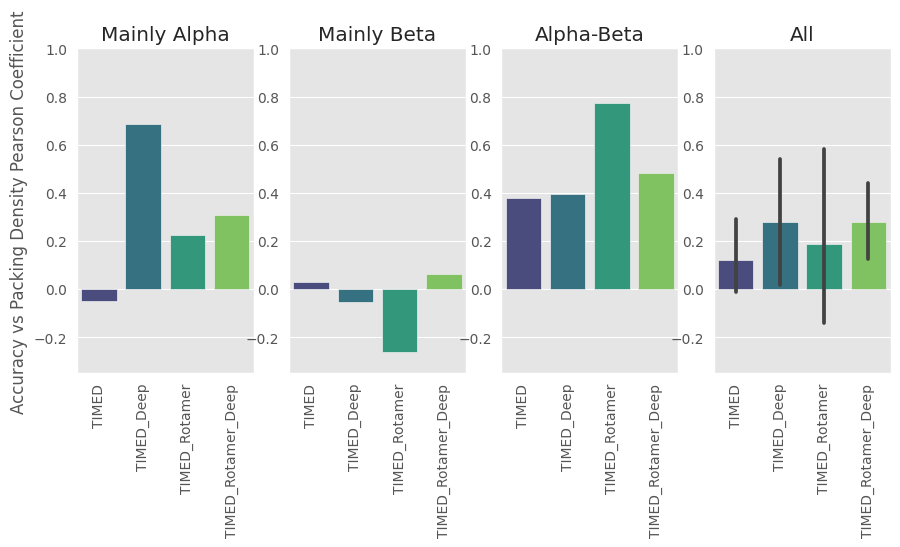

In [197]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'pearson', 'p-value'])
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", palette="viridis", ax=curr_ax)
        #curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson",  palette="viridis", ax=curr_ax)
        #curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(-0.35,1)
    if i==0:
        curr_ax.set_ylabel("Accuracy vs Packing Density Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")


In [198]:
pearson_df.to_csv('1accuracy_packing_density.csv')

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


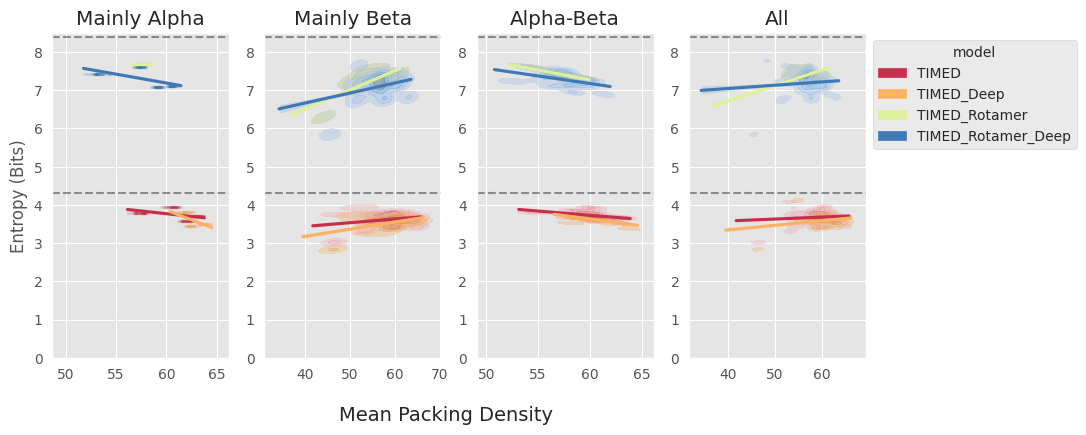

In [199]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
results_corr = []

class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_packdensity_mean"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = True
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2)], x=selected_x, y=selected_y, hue="model", legend=True, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        #curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (Bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_ylim(ymin=0, ymax=8.5)
    curr_ax.axhline(8.4,  ls='--', alpha=0.4, color=(0, 0, 0))
    curr_ax.axhline(4.32,  ls='--', alpha=0.4, color=(0, 0, 0))


    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r'Mean Packing Density', ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)
sns.move_legend(ax4, "upper left", bbox_to_anchor=(1, 1))

#plt.show()

In [76]:
results_corr

[['TIMED',
  'All',
  'All',
  'seq_accuracy',
  'curr_rmsd',
  -0.5679697994532538,
  0.0],
 ['TIMED',
  'Mainly Alpha',
  0.2,
  'seq_accuracy',
  'curr_rmsd',
  -0.5958413081722606,
  2.5251738336425453e-39],
 ['TIMED',
  'Mainly Beta',
  0.2,
  'seq_accuracy',
  'curr_rmsd',
  -0.12420674960060375,
  6.849629733903711e-11],
 ['TIMED',
  'Alpha-Beta',
  0.2,
  'seq_accuracy',
  'curr_rmsd',
  -0.4814529527703782,
  2.7907633858529123e-116],
 ['TIMED',
  'Mainly Alpha',
  1.0,
  'seq_accuracy',
  'curr_rmsd',
  -0.37723018058312335,
  5.653113141693959e-15],
 ['TIMED',
  'Mainly Beta',
  1.0,
  'seq_accuracy',
  'curr_rmsd',
  -0.4071540061203742,
  7.591602569433752e-115],
 ['TIMED',
  'Alpha-Beta',
  1.0,
  'seq_accuracy',
  'curr_rmsd',
  -0.4792468059698001,
  1.1812834839563648e-115],
 ['TIMED',
  'Mainly Alpha',
  0.6,
  'seq_accuracy',
  'curr_rmsd',
  -0.6720877057597507,
  6.875837163641471e-54],
 ['TIMED',
  'Mainly Beta',
  0.6,
  'seq_accuracy',
  'curr_rmsd',
  -0.322440

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


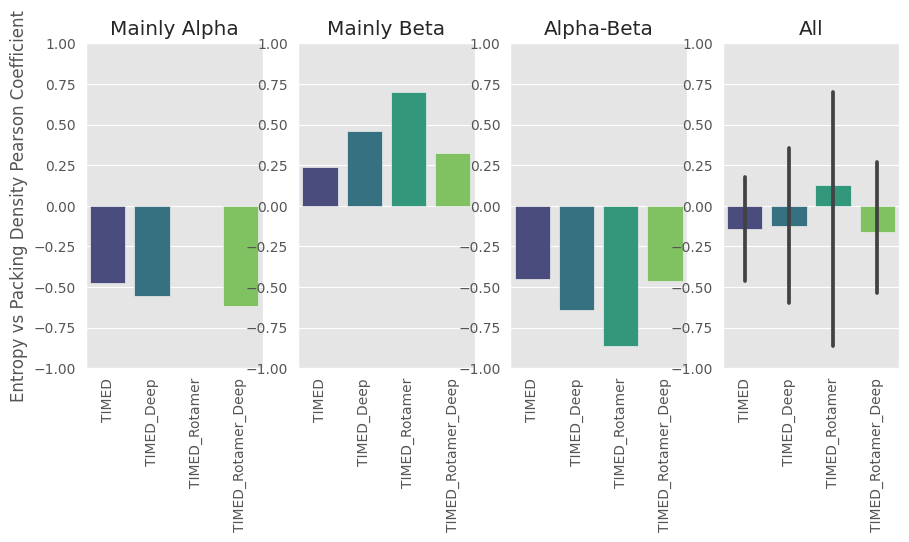

In [200]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'pearson', 'p-value'])
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", palette="viridis", ax=curr_ax)
        #curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson",  palette="viridis", ax=curr_ax)
        #curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(-1,1)
    if i==0:
        curr_ax.set_ylabel("Entropy vs Packing Density Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")


In [201]:
pearson_df.to_csv('1entropy_packing_density.csv')

In [180]:
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'pearson', 'p-value'])

In [ ]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(-1, 1)
    if i==0:
        curr_ax.set_ylabel("Entropy vs AF2 iDDT Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")


In [178]:
pd.DataFrame(results_corr).to_csv("corr_packing_density.csv")

### RMSD at t=1

<AxesSubplot:xlabel='model', ylabel='curr_rmsd'>

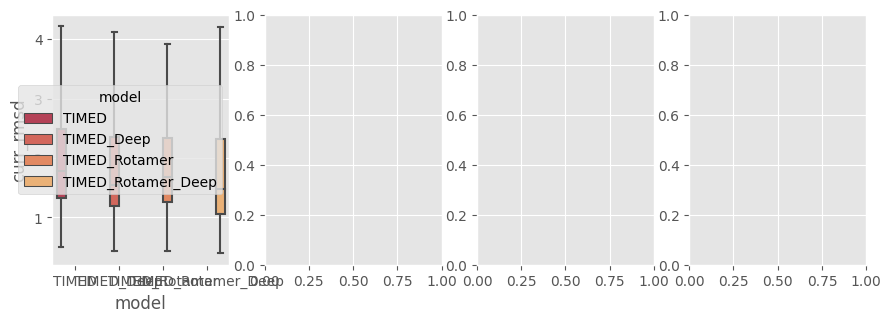

In [306]:
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
sns.boxplot(data=results_arr[results_arr['temp']==0.2], x='model',y='curr_rmsd', hue='model', ax =ax, showfliers = False, palette=sns.color_palette("Spectral", n_colors=len(model_names)))

In [73]:
results_arr


,model,pdb,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
0,TIMED,1jdwA,18,0.2,34.166667,3.678318,0.844525,63.186458,11.135536,67.227083,11.347349,87.245694,9.795477,1.509934,3.0
10725,TIMED,1jofA,18,1.0,18.082192,3.615823,0.846939,47.448630,14.081618,67.232877,12.681753,31.735342,8.164679,5.505128,2.0
10726,TIMED,1jovA,11,0.6,24.535316,3.757612,0.800340,62.976766,12.846912,67.093866,11.911091,86.522491,9.929447,1.468143,2.0
10727,TIMED,1genA,12,0.2,29.500000,3.745350,0.753623,59.120625,13.622439,63.223125,14.654425,88.632400,7.692256,1.941511,2.0
10728,TIMED,1genA,3,1.0,17.000000,3.745350,0.753623,47.938125,11.704032,63.223125,14.654425,34.682250,7.558033,9.217260,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18376,TIMED_Deep,1j3aA,8,0.2,40.310078,3.524370,0.969991,59.642442,11.855372,61.991279,11.313368,91.083953,8.717826,0.905026,3.0
18375,TIMED_Deep,1igqA,15,0.6,14.814815,3.736914,0.658772,36.557870,8.573036,61.497685,13.034176,61.874074,7.825935,8.027874,2.0
18374,TIMED_Deep,1muwA,9,0.6,31.088083,3.500520,1.022110,60.259715,12.652950,65.497409,12.341737,80.536347,12.772192,2.181285,3.0
18372,TIMED_Deep,1kcfA,17,0.6,25.416667,3.802885,0.562491,59.874479,11.326071,62.054688,12.837423,78.955750,12.795936,3.852104,3.0


In [75]:
results_arr.groupby(["model", "class", "pdb"]).mean()

n      temp  seq_accuracy  curr_entropy_mean  \
model      class pdb                                                          
TIMED      1.0   1a41A  9.661017  0.606780     18.544367           3.932107   
                 1dvoA  9.500000  0.600000     28.092105           3.797704   
                 1gxmA  9.500000  0.600000     29.084362           3.696182   
                 1h32A  9.500000  0.600000     27.075351           3.568738   
           2.0   1b2pA  9.500000  0.600000     23.431373           3.686873   
...                          ...       ...           ...                ...   
TIMED_Deep 3.0   1jkeA  8.676471  0.423529     32.170385           3.669540   
                 1kcfA  8.772727  0.545455     25.189394           3.802885   
                 1kkoA  8.103448  0.862069     27.754006           3.434350   
                 1muwA  8.200000  0.504000     34.777202           3.500520   
           4.0   1a92A  9.743590  0.394872     14.410256           4.113872   

                        curr_entropy_std  curr_packdensity_mean  \
model      class pdb                                              
TIMED      1.0   1a41A          0.496808              54.057085   
                 1dvoA          0.685363              54.427947   
                 1gxmA          0.786810              60.217798   
                 1h32A          1.022330              58.118595   
           2.0   1b2pA          0.760758              50.474405   
...                                  ...                    ...   
TIMED_Deep 3.0   1jkeA          0.730593              57.946298   
                 1kcfA          0.562491              58.453021   
                 1kkoA          0.973210              61.079350   
                 1muwA          1.022110              60.811808   
           4.0   1a92A          0.320278              53.115962   

                        curr_packdensity_std  real_packdensity_mean  \
model      class pdb                                                  
TIMED      1.0   1a41A             11.463342              60.153281   
                 1dvoA              9.953676              62.264803   
                 1gxmA             12.403559              70.245370   
                 1h32A             11.954078              71.750000   
           2.0   1b2pA             12.919568              66.403361   
...                                      ...                    ...   
TIMED_Deep 3.0   1jkeA             12.764509              63.430172   
                 1kcfA             11.730621              62.054688   
                 1kkoA             12.422780              73.187044   
                 1muwA             13.263729              65.497409   
           4.0   1a92A              9.348298              61.617500   

                        real_packdensity_std  curr_bfactor_mean  \
model      class pdb                                              
TIMED      1.0   1a41A             11.625747          53.303347   
                 1dvoA              9.892732          68.803038   
                 1gxmA             12.220907          72.833266   
                 1h32A             10.425117          73.580439   
           2.0   1b2pA             11.840418          51.049739   
...                                      ...                ...   
TIMED_Deep 3.0   1jkeA             12.297391          85.439430   
                 1kcfA             12.837423          71.861979   
                 1kkoA              9.025652          77.490924   
                 1muwA             12.341737          85.163973   
           4.0   1a92A             10.553151          78.330463   

                        curr_bfactor_std  curr_rmsd  
model      class pdb                                 
TIMED      1.0   1a41A          8.979761   6.004140  
                 1dvoA          8.006708   4.031281  
                 1gxmA         11.533956   3.055731  
                 1h32A          9.479314   3.179973  
           

In [171]:
results_arr.groupby(["model", "class", "temp"]).mean().to_csv('all_data_avg.csv')

In [170]:
results_arr.groupby(["model", "class", "temp"]).sum().to_csv('all_data_sum.csv')

In [167]:
!pip install tabulate

In [202]:
data_rmsd

NameError: name 'data_rmsd' is not defined